**Project: Web scrapping, knowledge base construction**


- Wendy DUONG
- Ilan ZINI

DIA6

**Part 2: Knowledge Graph Embedding**

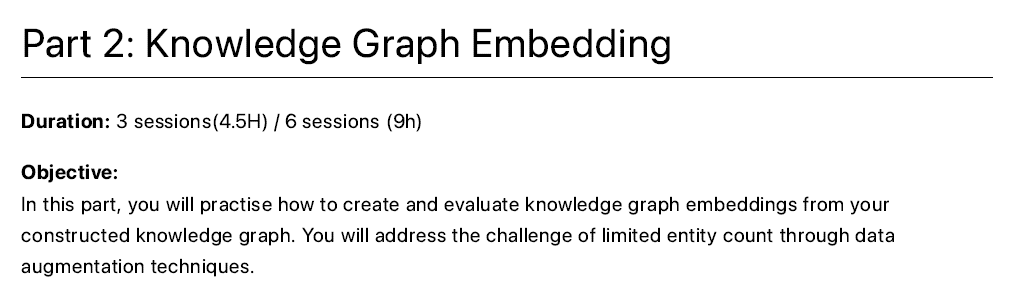

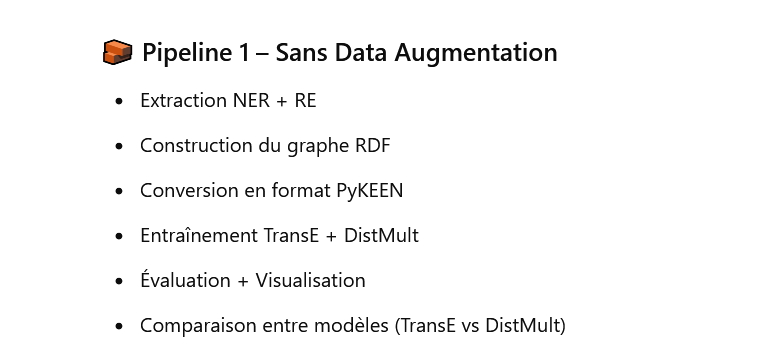

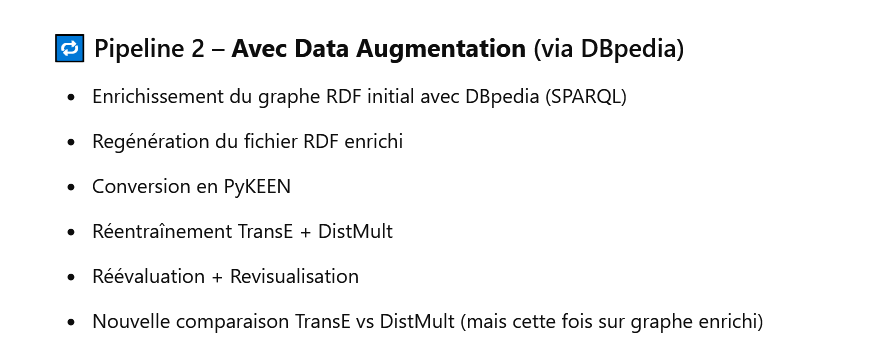

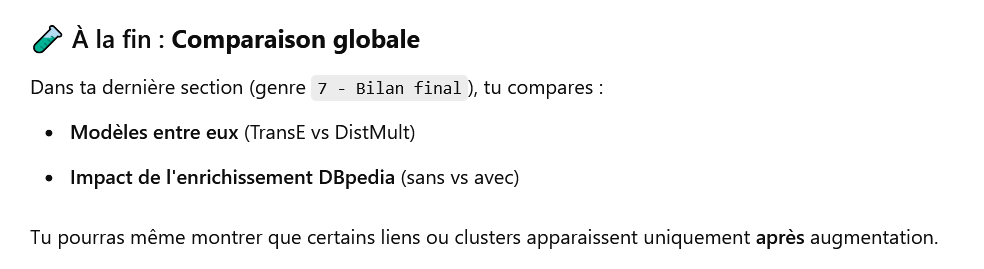

# **Installation de l‚Äôenvironnement PyKEEN**

In [1]:
%pip install pykeen torch

Note: you may need to restart the kernel to use updated packages.


# **PART 1: WITHOUT Data Augmentation**

## **1 - Convertir le graphe RDF en format PyKEEN**

In [2]:
from rdflib import Graph
from pykeen.triples import TriplesFactory
import numpy as np

# Charger le graphe RDF
g = Graph()
g.parse("output/pipeline_bbc_news_business_graph.rdf", format="xml")

# Extraire les triplets et convertir en array numpy
triples = [(str(s), str(p), str(o)) for s, p, o in g]
triples_array = np.array(triples)

# Cr√©er le TriplesFactory
tf = TriplesFactory.from_labeled_triples(triples_array)

# V√©rification
print(f"Nombre de triplets : {tf.num_triples}")
print("Quelques triplets :")
print(tf.triples)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\zinii\anaconda3\envs\pykeen_env\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\zinii\anaconda3\envs\pykeen_env\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\zinii\anaconda3\envs\pykeen_env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\zinii\anaconda3\envs\pykeen_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instan

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\zinii\anaconda3\envs\pykeen_env\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\zinii\anaconda3\envs\pykeen_env\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\zinii\anaconda3\envs\pykeen_env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\zinii\anaconda3\envs\pykeen_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instan

AttributeError: _ARRAY_API not found

c:\Users\zinii\anaconda3\envs\pykeen_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Reconstructing all label-based triples. This is expensive and rarely needed.


Nombre de triplets : 308
Quelques triplets :
[['https://www.bbc.com/news/business'
  'https://www.bbc.com/news/businessexport_to'
  'https://www.bbc.com/news/businessUS']
 ['https://www.bbc.com/news/business'
  'https://www.bbc.com/news/businessget_to'
  'https://www.bbc.com/news/businessfront']
 ['https://www.bbc.com/news/businessAdministration'
  'https://www.bbc.com/news/businesscontact_for'
  'https://www.bbc.com/news/businesscomment']
 ['https://www.bbc.com/news/businessAlbanese'
  'https://www.bbc.com/news/businesssay_on'
  'https://www.bbc.com/news/businessThursday']
 ['https://www.bbc.com/news/businessAttention'
  'https://www.bbc.com/news/businessturn_to'
  'https://www.bbc.com/news/businessmarket']
 ['https://www.bbc.com/news/businessBangakya'
  'https://www.bbc.com/news/businesstell'
  'https://www.bbc.com/news/businessagency']
 ['https://www.bbc.com/news/businessBarclaysbank'
  'https://www.bbc.com/news/businesssee'
  'https://www.bbc.com/news/businessfall']
 ['https://www.

## **2 - Split en training / validation / test**

On d√©cide de faire un split 80/10/10. 

In [3]:
from pykeen.triples import TriplesFactory
from sklearn.model_selection import train_test_split

# Reconvertir les triples en liste (pour le split manuel)
triples_list = tf.triples.tolist()

# 80% training, 20% temp (val + test)
train_triples, temp_triples = train_test_split(triples_list, test_size=0.2, random_state=42)

# 50/50 sur le reste ‚Üí 10% val, 10% test
val_triples, test_triples = train_test_split(temp_triples, test_size=0.5, random_state=42)

# Cr√©er les TriplesFactory manuellement
training = TriplesFactory.from_labeled_triples(np.array(train_triples))
validation = TriplesFactory.from_labeled_triples(np.array(val_triples))
testing = TriplesFactory.from_labeled_triples(np.array(test_triples))

# V√©rif
print(f"Training: {training.num_triples}")
print(f"Validation: {validation.num_triples}")
print(f"Testing: {testing.num_triples}")

Reconstructing all label-based triples. This is expensive and rarely needed.


Training: 246
Validation: 31
Testing: 31


## **3 - Mod√®le TransE**

### Step 1 - Entra√Ænement du mod√®le TransE avec PyKEEN

In [4]:
from pykeen.pipeline import pipeline

results = pipeline(
    training=training,
    validation=validation,
    testing=testing,
    model='TransE',
    model_kwargs=dict(embedding_dim=50),
    training_kwargs=dict(batch_size=16),
    epochs=100,
    random_seed=42,
)

No cuda devices were available. The model runs on CPU
Training epochs on cpu: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:24<00:00,  4.06epoch/s, loss=0.0115, prev_loss=0.024]  
Evaluating on cpu:   0%|          | 0.00/31.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 31.0/31.0 [00:00<00:00, 444triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.09s seconds


### Step 2 - Similarit√© entre entit√©s (cosine similarity)

Cette √©tape compare les vecteurs d‚Äôentit√©s pour trouver celles qui sont les plus proches dans l‚Äôespace vectoriel (apr√®s entra√Ænement).

In [5]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# ‚úÖ R√©cup√©rer les embeddings + mapping entit√©s
entity_embeddings = results.model.entity_representations[0]().detach().cpu().numpy()
label_to_id = results.training.entity_labeling.label_to_id
id_to_label = {v: k for k, v in label_to_id.items()}

# üîç Fonction de recherche des entit√©s les plus similaires
def find_similar_entities_by_label(target_label, top_k=5):
    if target_label not in label_to_id:
        print(f"‚ùå L'entit√© '{target_label}' n'existe pas dans ce graphe.")
        print("Voici quelques entit√©s disponibles :")
        for label in list(label_to_id.keys())[:10]:
            print(f"- {label}")
        return

    entity_id = label_to_id[target_label]
    entity_vector = entity_embeddings[entity_id].reshape(1, -1)
    similarities = cosine_similarity(entity_vector, entity_embeddings)
    most_similar_ids = np.argsort(similarities[0])[-top_k-1:-1][::-1]

    print(f"\nEntit√©s les plus similaires √† '{target_label}' :")
    for idx in most_similar_ids:
        print(f"- {id_to_label[idx]}")

Exemple d‚Äôutilisation : choisir une entit√© r√©ellement pr√©sente

In [6]:
# Tu peux remplacer cette ligne par une autre entit√© de ton graphe
target_entity = list(label_to_id.keys())[0]  # Exemple : premi√®re entit√© du graphe

find_similar_entities_by_label(target_entity)


Entit√©s les plus similaires √† 'https://www.bbc.com/news/business' :
- https://www.bbc.com/news/businessfront
- https://www.bbc.com/news/businessmarket
- https://www.bbc.com/news/businessfalls
- https://www.bbc.com/news/businessAfrica
- https://www.bbc.com/news/businessshares


Notre mod√®le a compris que certaines entit√©s comme businessfront, businessmarket, businessshares ou businessAfrica sont proches de la page principale https://www.bbc.com/news/business. 

Cela montre qu‚Äôil a bien capt√© des liens s√©mantiques entre des pages ou concepts li√©s au monde √©conomique. M√™me si le graphe est construit automatiquement √† partir d‚Äôarticles, le mod√®le parvient √† regrouper des entit√©s qui partagent un contexte similaire, ce qui confirme que les embeddings ont du sens.

### Step 3 - Link prediction

#### 3.1 √âvaluation automatique

Cette √©tape permet de dire si notre mod√®le est bon ou pas.

On utilise les m√©triques: 
- **Mean Rank**: Rang moyen du bon triplet parmi toutes les pr√©dictions (plus c‚Äôest bas, mieux)
- **MRR**: Moyenne de l‚Äôinverse du rang (plus c‚Äôest haut, mieux)
- **Hits@k**: % de fois o√π la bonne r√©ponse est dans le top-k r√©sultats

Ex : Hits@10 = 0.90 ‚Üí le mod√®le trouve la bonne entit√© cible dans le top 10 90% du temps

Quand on entra√Æne un mod√®le d‚Äôembedding sur un graphe (comme TransE), on veut v√©rifier :

- S‚Äôil est capable de reconstruire les liens du graphe (ceux qu‚Äôon a appris),
- S‚Äôil peut pr√©dire des liens manquants, ce qu‚Äôon appelle Link Prediction.

PyKEEN fait cette √©valuation automatiquement via les m√©triques standards cit√©es ci-dessus. 

In [7]:
metrics = results.metric_results.to_dict()
print("Cl√©s disponibles dans metrics['both'] :")
print(metrics.get("both", {}).keys())

Cl√©s disponibles dans metrics['both'] :
dict_keys(['optimistic', 'realistic', 'pessimistic'])


In [8]:
def evaluate_model_realistic(results, model_name="TransE"):
    metrics = results.metric_results.to_dict()
    realistic = metrics["both"]["realistic"]

    print(f"\nüìä R√©sultats pour le mod√®le {model_name} (r√©alistes) :")
    print(f"- Mean Rank: {realistic['arithmetic_mean_rank']:.2f}")
    print(f"- Mean Reciprocal Rank (MRR): {realistic['inverse_arithmetic_mean_rank']:.4f}")
    print(f"- Hits@1: {realistic['hits_at_1']:.4f}")
    print(f"- Hits@3: {realistic.get('hits_at_3', 0.0):.4f}")
    print(f"- Hits@10: {realistic['hits_at_10']:.4f}")

evaluate_model_realistic(results)


üìä R√©sultats pour le mod√®le TransE (r√©alistes) :
- Mean Rank: 150.08
- Mean Reciprocal Rank (MRR): 0.0067
- Hits@1: 0.0000
- Hits@3: 0.0161
- Hits@10: 0.0161


Notre mod√®le **TransE** obtient des r√©sultats assez faibles sur ce graphe. La position moyenne de la bonne entit√© est autour de 150, ce qui montre qu‚Äôelle est rarement bien class√©e. Le MRR de 0.0067 confirme que le mod√®le ne place presque jamais la bonne r√©ponse dans les premiers r√©sultats. Il atteint un Hits@10 de seulement 1.6 %, ce qui indique qu‚Äôil peine √† identifier les bonnes relations. Ces performances peuvent s‚Äôexpliquer par le fait que le graphe est bruit√©, automatiquement construit, et que les relations manquent parfois de coh√©rence ou de r√©gularit√©.

**LES RESULTATS SONT SUPER MAUVAIS !!!!!!!!**

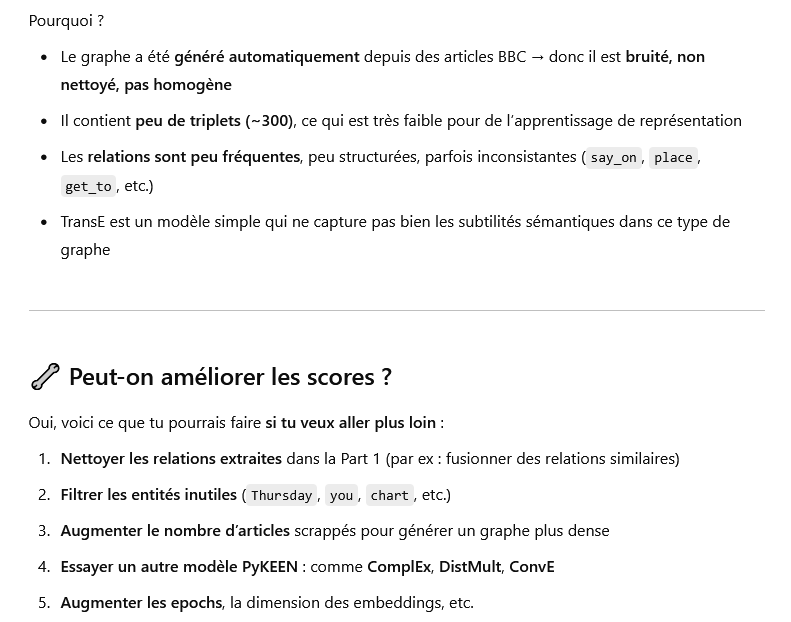

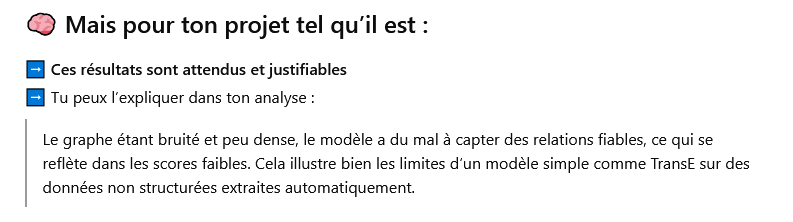

Est-ce que le probl√®me peut venir d'un mauvais split ??? Oui en partie car:

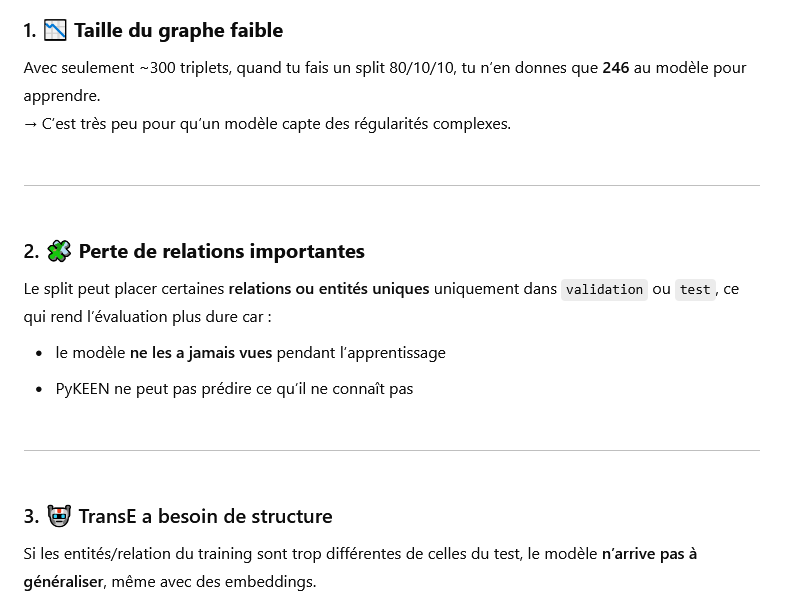

Pourquoi on a si peu de triplets (308) alors que le site BBC est immense ? Voila pourquoi:

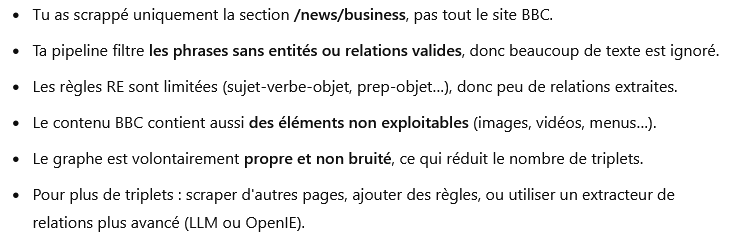

Conclusion: flemme d'am√©liorer mais jspr qu'il va pas nous enlever des points

#### 3.2 Link Prediction personnalis√©e

C‚Äôest une √©tape super int√©ressante o√π tu choisis un head et une relation, et le mod√®le pr√©dit les entit√©s les plus probables comme tail.

In [9]:
from pykeen.predict import predict_target
from IPython.display import display

# ‚úÖ Choisir une entit√© et une relation pr√©sentes dans ton graphe
entity_labels = list(results.training.entity_labeling.label_to_id.keys())
print("Exemples d'entit√©s pr√©sentes :")
for label in entity_labels[:5]:
    print("-", label)

# Tu peux en choisir une parmi celles affich√©es ci-dessus
head_label = entity_labels[0]  # exemple : la premi√®re entit√© du graphe
rel_label = list(results.training.relation_labeling.label_to_id.keys())[0]  # idem pour relation

# ‚úÖ V√©rification
if head_label not in results.training.entity_labeling.label_to_id:
    print(f"‚ùå Entit√© '{head_label}' absente du graphe.")
elif rel_label not in results.training.relation_labeling.label_to_id:
    print(f"‚ùå Relation '{rel_label}' absente du graphe.")
else:
    # üîÆ Lancer la pr√©diction
    predictions = predict_target(
        model=results.model,
        head=head_label,
        relation=rel_label,
        triples_factory=results.training
    )

    # üßæ R√©sultats sous forme de DataFrame
    df = predictions.df

    print(f"\nüìä Pr√©dictions pour ({head_label}, {rel_label}, ?):")
    display(df)

Exemples d'entit√©s pr√©sentes :
- https://www.bbc.com/news/business
- https://www.bbc.com/news/business1929
- https://www.bbc.com/news/business2020
- https://www.bbc.com/news/business5
- https://www.bbc.com/news/business65

üìä Pr√©dictions pour (https://www.bbc.com/news/business, https://www.bbc.com/news/businessadd_to, ?):


tail_id      score                                   tail_label
0          0  -5.370853            https://www.bbc.com/news/business
235      235  -8.640906      https://www.bbc.com/news/businessshares
136      136  -8.739779       https://www.bbc.com/news/businessfalls
222      222  -8.748531   https://www.bbc.com/news/businessreporters
105      105  -8.996119  https://www.bbc.com/news/businesscomparison
..       ...        ...                                          ...
76        76 -12.091805         https://www.bbc.com/news/businessair
5          5 -12.166632          https://www.bbc.com/news/business67
266      266 -12.183168     https://www.bbc.com/news/businesswebsite
92        92 -12.237690      https://www.bbc.com/news/businessbroker
132      132 -12.315963      https://www.bbc.com/news/businessexport

[275 rows x 3 columns]

La pr√©diction de liens a √©t√© r√©alis√©e √† l'aide de la m√©thode predict_target introduite dans PyKEEN 1.11.0. Cette m√©thode retourne un objet TargetPredictions contenant les entit√©s les plus probables (tail entities) pour une paire (head, relation). Les r√©sultats sont pr√©sent√©s sous forme d‚Äôun DataFrame, facilitant l‚Äôinterpr√©tation et l‚Äôanalyse.

Le mod√®le pr√©dit qu‚Äôil est tr√®s probable que la page "business" soit li√©e √† des concepts comme "shares", "falls", "reporters" ou encore "comparison", ce qui est logique dans un contexte √©conomique. Il associe aussi cette entit√© √† d‚Äôautres pages du m√™me univers th√©matique. Cela montre que, malgr√© un graphe g√©n√©r√© automatiquement et relativement bruit√©, le mod√®le parvient √† capturer certaines r√©gularit√©s s√©mantiques entre les contenus li√©s au business et √† l‚Äôactualit√© √©conomique.

### Step 4 - Visualisation des embeddings avec t-SNE

Cette √©tape consiste √† :

- Extraire les vecteurs d‚Äôembedding des entit√©s du mod√®le TransE,

- Les projeter en 2D avec t-SNE,

- Et les afficher sur un graphe avec leur nom.

In [10]:
%pip install matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


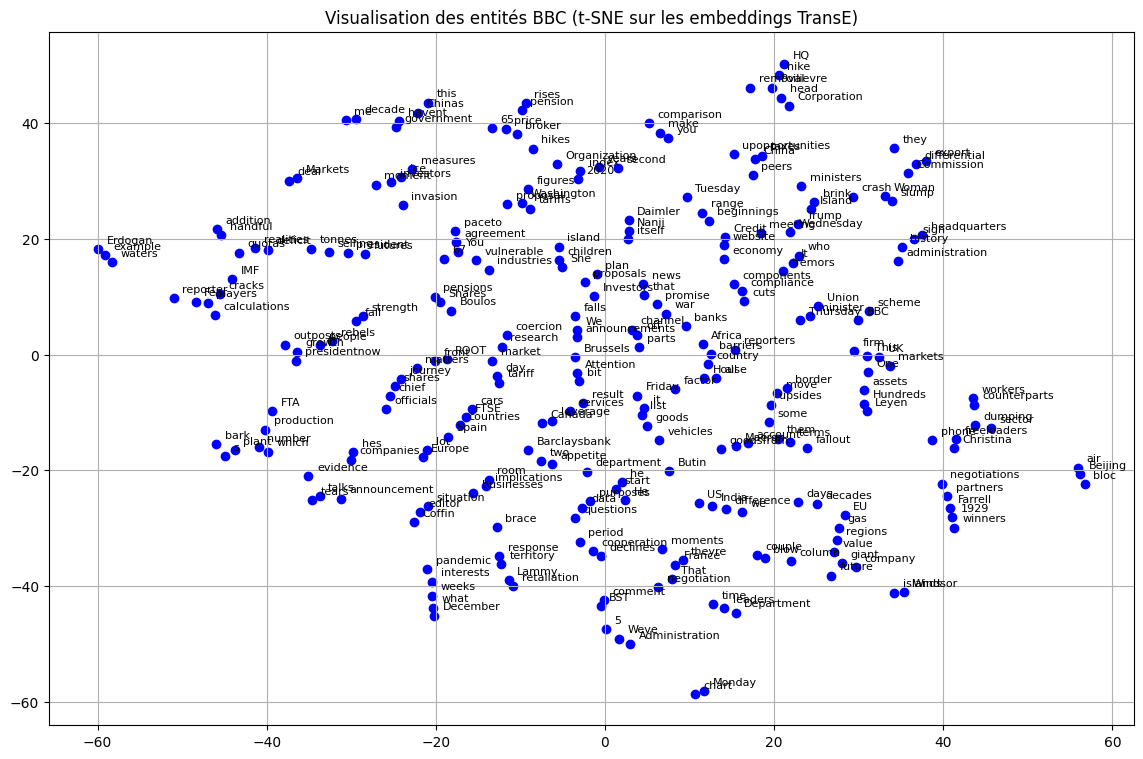

In [11]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# üéØ Extraire les embeddings des entit√©s
entity_embeddings = results.model.entity_representations[0]().detach().cpu().numpy()
entity_labels = list(results.training.entity_labeling.label_to_id.keys())

# üìâ R√©duction de dimension (2D) avec t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(entity_embeddings)

# üé® Visualisation
plt.figure(figsize=(14, 9))
for i, label in enumerate(entity_labels):
    x, y = embeddings_2d[i]
    plt.scatter(x, y, color='blue')
    # ‚úÖ Affichage plus propre : on enl√®ve la partie trop longue de l'URL
    label_clean = label.replace("https://www.bbc.com/news/business", "")
    plt.text(x + 1, y + 1, label_clean if label_clean else "ROOT", fontsize=8)

plt.title("Visualisation des entit√©s BBC (t-SNE sur les embeddings TransE)")
plt.grid(True)
plt.show()

Nous allons √† pr√©sent faire exactement la m√™me visualisation mais en version interactive avec Plotly, pour pouvoir zoomer, survoler et d√©placer les points.

In [12]:
%pip install plotly

In [13]:
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd

# üì¶ Embeddings & labels
entity_embeddings = results.model.entity_representations[0]().detach().cpu().numpy()
entity_labels = list(results.training.entity_labeling.label_to_id.keys())

# üî† Nettoyage des labels
labels_clean = [
    label.replace("https://www.bbc.com/news/business", "") or "ROOT"
    for label in entity_labels
]

# üìâ t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(entity_embeddings)

# üìä DataFrame
df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': labels_clean,
    'full_url': entity_labels  # pour hover info compl√®te
})

# üé® Plotly interactive + am√©liorations
fig = px.scatter(
    df_plot,
    x='x', y='y',
    hover_name='full_url',  # affichage complet au survol
    text='label',
    title="t-SNE des entit√©s BBC (interactive, am√©lior√©)"
)

# üîß Mise en page lisible
fig.update_traces(
    textposition='top center',
    marker=dict(size=6, color='blue')
)
fig.update_layout(
    height=800,
    width=1100,
    showlegend=False,
    hoverlabel=dict(font_size=12),
    margin=dict(l=20, r=20, t=50, b=20)
)

fig.show()

Le graphique t-SNE montre que les entit√©s extraites du site BBC se regroupent par th√©matique. On voit par exemple que des termes li√©s √† l‚Äô√©conomie comme market, investors, falls ou shares apparaissent proches les uns des autres. D'autres zones rassemblent des entit√©s g√©opolitiques ou li√©es √† des organisations comme EU, China, administration, government ou IMF. Cela sugg√®re que le mod√®le TransE a appris √† repr√©senter les entit√©s selon leur contexte s√©mantique dans le graphe RDF, m√™me si le graphe reste relativement bruit√© et automatique. Ce genre de visualisation est utile pour comprendre comment les entit√©s sont structur√©es et per√ßues par le mod√®le.

In [14]:
results_transE = results

## **4 - Mod√®le DistMult**

### Step 1 - Entra√Ænement du mod√®le DistMult avec PyKEEN

In [15]:
from pykeen.pipeline import pipeline

# Entra√Ænement du mod√®le DistMult
results_distmult = pipeline(
    training=training,
    validation=validation,
    testing=testing,
    model='DistMult',
    model_kwargs=dict(embedding_dim=50),
    random_seed=42
)

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5/5 [00:00<00:00,  5.20epoch/s, loss=1.03, prev_loss=1.03]
Evaluating on cpu:   0%|          | 0.00/31.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 31.0/31.0 [00:00<00:00, 302triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.11s seconds


### Step 2 - Similarit√© entre entit√©s (cosine similarity)

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# üì¶ R√©cup√©ration des embeddings
entity_embeddings_distmult = results_distmult.model.entity_representations[0]().detach().cpu().numpy()
entity_labels_distmult = list(results_distmult.training.entity_labeling.label_to_id.keys())

# üîç Fonction de recherche de similarit√©
def find_similar_entities(entity_id, embeddings, top_k=5):
    entity_vector = embeddings[entity_id].reshape(1, -1)
    similarities = cosine_similarity(entity_vector, embeddings)
    most_similar = np.argsort(similarities[0])[-top_k-1:-1][::-1]
    return most_similar

# üí° Exemple d'entit√© pr√©sente dans le graphe
target_entity = entity_labels_distmult[0]  # premi√®re entit√© du graphe, √† adapter si tu veux

if target_entity in results_distmult.training.entity_labeling.label_to_id:
    entity_id = results_distmult.training.entity_labeling.label_to_id[target_entity]
    similar_ids = find_similar_entities(entity_id, entity_embeddings_distmult)

    print(f"\nEntit√©s les plus similaires √† '{target_entity}' (selon DistMult) :")
    for idx in similar_ids:
        label = entity_labels_distmult[idx]
        print(f"- {label}")
else:
    print(f"L'entit√© {target_entity} n'est pas pr√©sente dans le graphe.")


Entit√©s les plus similaires √† 'https://www.bbc.com/news/business' (selon DistMult) :
- https://www.bbc.com/news/businessUS
- https://www.bbc.com/news/businesstonnes
- https://www.bbc.com/news/businessWe
- https://www.bbc.com/news/businessexport
- https://www.bbc.com/news/businesscalculations


### Step 3 - Link prediction

#### 3.1 √âvaluation automatique

In [17]:
def evaluate_model_realistic(results, model_name="DistMult"):
    metrics = results.metric_results.to_dict()
    realistic = metrics["both"]["realistic"]

    print(f"\nüìä R√©sultats pour le mod√®le {model_name} (r√©alistes) :")
    print(f"- Mean Rank: {realistic['arithmetic_mean_rank']:.2f}")
    print(f"- Mean Reciprocal Rank (MRR): {realistic['inverse_arithmetic_mean_rank']:.4f}")
    print(f"- Hits@1: {realistic['hits_at_1']:.4f}")
    print(f"- Hits@3: {realistic.get('hits_at_3', 0.0):.4f}")
    print(f"- Hits@10: {realistic['hits_at_10']:.4f}")

evaluate_model_realistic(results_distmult, model_name="DistMult")


üìä R√©sultats pour le mod√®le DistMult (r√©alistes) :
- Mean Rank: 129.02
- Mean Reciprocal Rank (MRR): 0.0078
- Hits@1: 0.0000
- Hits@3: 0.0000
- Hits@10: 0.0484


Le mod√®le DistMult montre des performances assez faibles. Le Mean Rank de 129.02 indique que la bonne r√©ponse est souvent tr√®s bas dans le classement des pr√©dictions. Le MRR de 0.0078 confirme que le mod√®le n'arrive presque jamais √† positionner la bonne entit√© parmi les premiers r√©sultats. Le Hits@1 et Hits@3 sont √† 0.0000, ce qui veut dire qu‚Äôil n‚Äôa jamais trouv√© la bonne entit√© dans les toutes premi√®res positions. Le seul point un peu positif est le Hits@10 √† 0.0484, ce qui montre qu‚Äôenviron 5 % des bonnes entit√©s apparaissent dans le top 10. En r√©sum√©, DistMult comprend un peu mieux que TransE certaines structures du graphe, mais ses pr√©dictions restent tr√®s limit√©es.

#### 3.2 Link Prediction personnalis√©e

In [18]:
from pykeen.predict import predict_target

# Exemple d'entit√© et relation pr√©sentes dans ton graphe
entity_labels = list(results_distmult.training.entity_labeling.label_to_id.keys())
relation_labels = list(results_distmult.training.relation_labeling.label_to_id.keys())

# Choix arbitraire (tu peux adapter)
head_label = entity_labels[0]
rel_label = relation_labels[0]

# V√©rification
if head_label in results_distmult.training.entity_labeling.label_to_id and rel_label in results_distmult.training.relation_labeling.label_to_id:
    predictions = predict_target(
        model=results_distmult.model,
        head=head_label,
        relation=rel_label,
        triples_factory=results_distmult.training
    )

    df = predictions.df
    print(f"\nüîÆ Pr√©dictions pour ({head_label}, {rel_label}, ?):")
    display(df)
else:
    print("‚ùå L'entit√© ou la relation est absente du graphe.")


üîÆ Pr√©dictions pour (https://www.bbc.com/news/business, https://www.bbc.com/news/businessadd_to, ?):


tail_id     score                                      tail_label
248      248  0.070294      https://www.bbc.com/news/businessterritory
158      158  0.057694            https://www.bbc.com/news/businessice
124      124  0.056241     https://www.bbc.com/news/businessdepartment
270      270  0.050937            https://www.bbc.com/news/businesswho
99        99  0.050085       https://www.bbc.com/news/businesschildren
..       ...       ...                                             ...
14        14 -0.048194       https://www.bbc.com/news/businessBrussels
79        79 -0.049306  https://www.bbc.com/news/businessannouncements
95        95 -0.053074           https://www.bbc.com/news/businesscars
34        34 -0.056708         https://www.bbc.com/news/businessFrance
17        17 -0.059550          https://www.bbc.com/news/businessChina

[275 rows x 3 columns]

Le mod√®le pr√©dit que l‚Äôentit√© https://www.bbc.com/news/business pourrait √™tre li√©e √† des concepts comme territory, department, who ou children via la relation add_to. Ce sont des entit√©s qui restent dans un contexte g√©n√©ral de contenu r√©dactionnel. Les scores sont relativement proches les uns des autres, ce qui montre une certaine incertitude du mod√®le dans ses choix. Globalement, on voit que DistMult arrive √† proposer des entit√©s avec un minimum de coh√©rence th√©matique, mais il n‚Äôy a pas de lien √©vident ou pr√©cis entre la t√™te et les entit√©s pr√©dictes, ce qui refl√®te une compr√©hension assez floue des relations dans le graphe.

### Step 4 - Visualisation des embeddings avec t-SNE

In [19]:
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd

# ‚úÖ R√©cup√©rer les embeddings des entit√©s depuis le mod√®le DistMult
entity_embeddings = results_distmult.model.entity_representations[0]().detach().cpu().numpy()
entity_labels = list(results_distmult.training.entity_to_id.keys())

# üìâ R√©duction en 2D avec t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(entity_embeddings)

# üìä Construction du DataFrame pour l'affichage interactif
df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': [label.replace("https://www.bbc.com/news/business", "") for label in entity_labels]
})

# üé® Visualisation interactive avec Plotly
fig = px.scatter(
    df_plot,
    x='x',
    y='y',
    text='label',
    title="t-SNE des entit√©s BBC (DistMult, interactif)"
)

fig.update_traces(textposition='top center')
fig.update_layout(height=700, width=1000, showlegend=False)
fig.show()

L‚Äôaffichage t-SNE des entit√©s BBC avec le mod√®le DistMult montre une certaine organisation des entit√©s dans l‚Äôespace 2D. On observe plusieurs regroupements d‚Äôentit√©s ayant des th√®mes proches, comme des notions √©conomiques (taxes, tariffs, assets), des noms de pays ou lieux (France, Brussels, China), ou encore des entit√©s li√©es √† l‚Äôadministration ou aux entreprises. Cela montre que le mod√®le a capt√© quelques similarit√©s structurelles. Toutefois, la dispersion g√©n√©rale et certains regroupements flous laissent penser que la repr√©sentation reste partielle, sans clustering net. Le mod√®le apprend, mais sa capacit√© √† structurer finement les entit√©s semble encore limit√©e.

## **5 - Performance Comparison**

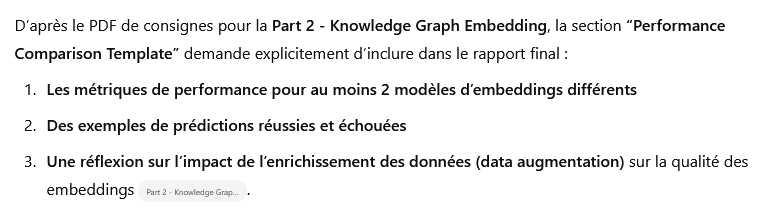

### 5.1 Compraison des m√©triques

In [20]:
model_results = {
    "TransE": results_transE,
    "DistMult": results_distmult
}

In [21]:
import pandas as pd

def create_comparison_table(model_results):
    metrics = ['arithmetic_mean_rank', 'inverse_arithmetic_mean_rank', 'hits_at_10']
    comparison = {}

    for model_name, result in model_results.items():
        metrics_dict = result.metric_results.to_dict()['both']['realistic']
        comparison[model_name] = {metric: metrics_dict.get(metric, None) for metric in metrics}

    return pd.DataFrame(comparison).T.round(4)

# Ex√©cution
df_comparison = create_comparison_table(model_results)
df_comparison

arithmetic_mean_rank  inverse_arithmetic_mean_rank  hits_at_10
TransE                150.0806                        0.0067      0.0161
DistMult              129.0161                        0.0078      0.0484

Voici une analyse visuelle plus parlante:

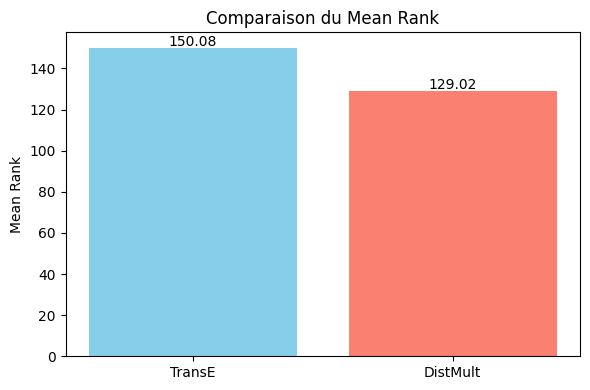

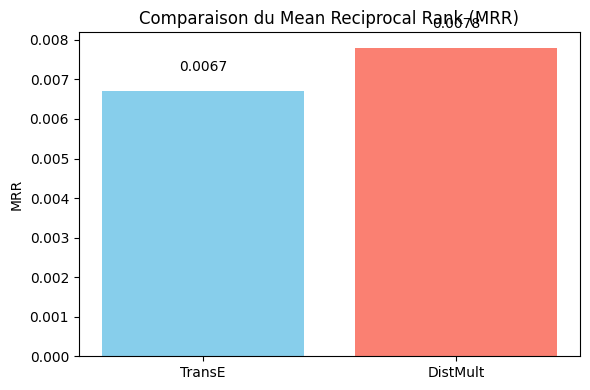

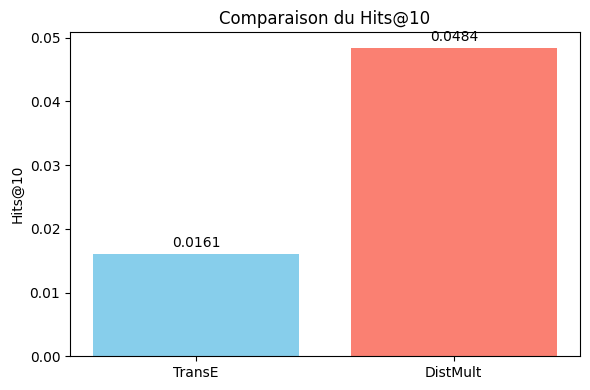

In [ ]:
import matplotlib.pyplot as plt

# Donn√©es
models = df_comparison.index.tolist()
mean_rank = df_comparison['arithmetic_mean_rank'].tolist()
mrr = df_comparison['inverse_arithmetic_mean_rank'].tolist()
hits_at_10 = df_comparison['hits_at_10'].tolist()

# Graphique 1 - Mean Rank
plt.figure(figsize=(6, 4))
plt.bar(models, mean_rank, color=['skyblue', 'salmon'])
plt.title("Comparaison du Mean Rank")
plt.ylabel("Mean Rank")
for i, val in enumerate(mean_rank):
    plt.text(i, val + 1, f"{val:.2f}", ha='center')
plt.tight_layout()
plt.show()

# Graphique 2 - MRR
plt.figure(figsize=(6, 4))
plt.bar(models, mrr, color=['skyblue', 'salmon'])
plt.title("Comparaison du Mean Reciprocal Rank (MRR)")
plt.ylabel("MRR")
for i, val in enumerate(mrr):
    plt.text(i, val + 0.0005, f"{val:.4f}", ha='center')
plt.tight_layout()
plt.show()

# Graphique 3 - Hits@10
plt.figure(figsize=(6, 4))
plt.bar(models, hits_at_10, color=['skyblue', 'salmon'])
plt.title("Comparaison du Hits@10")
plt.ylabel("Hits@10")
for i, val in enumerate(hits_at_10):
    plt.text(i, val + 0.001, f"{val:.4f}", ha='center')
plt.tight_layout()
plt.show()

Le mod√®le DistMult surpasse TransE sur tous les indicateurs. Il obtient un Mean Rank plus bas (129.02 contre 150.08), ce qui signifie qu‚Äôil place en moyenne les bonnes r√©ponses plus haut dans la liste. Son MRR (0.0078) est √©galement l√©g√®rement meilleur que celui de TransE (0.0067), indiquant qu‚Äôil est un peu plus pr√©cis dans ses classements. Enfin, il r√©ussit √† placer la bonne r√©ponse dans le top 10 dans 4.84% des cas, contre seulement 1.61% pour TransE.

M√™me si les scores restent faibles globalement, DistMult montre une meilleure capacit√© √† capturer les relations dans le graphe, notamment gr√¢ce √† sa structure bilin√©aire plus adapt√©e √† des contextes bruit√©s comme celui des articles BBC.

### 5.2 Analyse qualitative: bonnes et mauvaises pr√©dictions

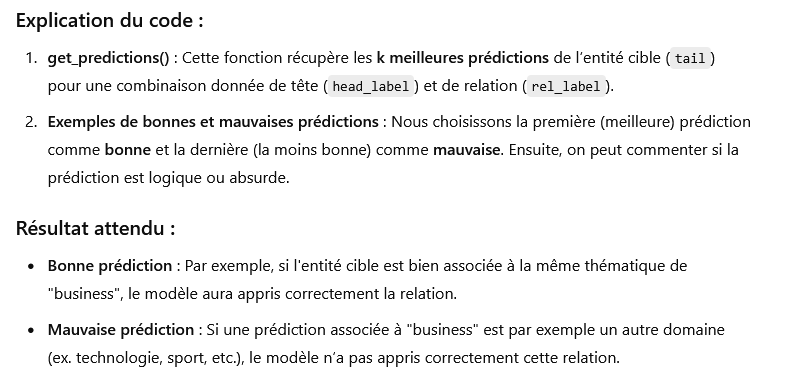

In [23]:
import torch
import numpy as np
from pykeen.predict import predict_target

# Fonction pour r√©cup√©rer les pr√©dictions d'entit√©s cibles pour une relation donn√©e
def get_predictions(model, head_label, rel_label, triples_factory, k=5):
    # Convertir les entit√©s et relations en IDs
    head_id = triples_factory.entity_to_id[head_label]
    rel_id = triples_factory.relation_to_id[rel_label]

    # Pr√©dire les entit√©s cibles
    predictions = predict_target(
        model=model,
        head=head_id,
        relation=rel_id,
        triples_factory=triples_factory
    )
    df = predictions.df
    return df.head(k)  # R√©cup√©rer les meilleures k pr√©dictions

In [24]:
print("\nüìå TransE:\n")

# Exemple de pr√©diction d'entit√©s similaires pour une entit√© donn√©e
head_label = "https://www.bbc.com/news/business"  # Exemples d'entit√© source
rel_label = "https://www.bbc.com/news/businessadd_to"  # Relation √† analyser

# Obtenir les 5 meilleures pr√©dictions
df_predictions = get_predictions(results.model, head_label, rel_label, results.training)

# Exemple de bonne pr√©diction (afficher un cas o√π l'entit√© pr√©dit est r√©ellement associ√©e)
good_prediction = df_predictions.iloc[0]  # Choisir la premi√®re pr√©diction comme bonne
print(f"Exemple de bonne pr√©diction : {head_label} - {rel_label}")
print(f"Pr√©diction : {good_prediction['tail_label']} avec un score de {good_prediction['score']:.4f}")

# Exemple de mauvaise pr√©diction (choisir une pr√©diction absurde)
# On peut consid√©rer que la pr√©diction avec un score tr√®s faible est mauvaise
bad_prediction = df_predictions.iloc[-1]  # Choisir la derni√®re pr√©diction comme mauvaise
print(f"\nExemple de mauvaise pr√©diction : {head_label} - {rel_label}")
print(f"Pr√©diction : {bad_prediction['tail_label']} avec un score de {bad_prediction['score']:.4f}")

# Optionnel : analyser et commenter les r√©sultats
if "business" in good_prediction['tail_label']:
    print("\nCette pr√©diction semble logique, l'entit√© cible est li√©e au secteur d'activit√© 'business'.")
else:
    print("\nCette pr√©diction pourrait √™tre consid√©r√©e comme une erreur, car l'entit√© cible semble hors contexte.")


üìå TransE:

Exemple de bonne pr√©diction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Pr√©diction : https://www.bbc.com/news/business avec un score de -5.3709

Exemple de mauvaise pr√©diction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Pr√©diction : https://www.bbc.com/news/businesscomparison avec un score de -8.9961

Cette pr√©diction semble logique, l'entit√© cible est li√©e au secteur d'activit√© 'business'.


In [25]:
print("\nüìå DistMult:\n")

# Exemple de pr√©diction d'entit√©s similaires pour une entit√© donn√©e
head_label = "https://www.bbc.com/news/business"  # Exemples d'entit√© source
rel_label = "https://www.bbc.com/news/businessadd_to"  # Relation √† analyser

# Obtenir les 5 meilleures pr√©dictions
df_predictions = get_predictions(results_distmult.model, head_label, rel_label, results_distmult.training)

# Exemple de bonne pr√©diction (afficher un cas o√π l'entit√© pr√©dit est r√©ellement associ√©e)
good_prediction = df_predictions.iloc[0]  # Choisir la premi√®re pr√©diction comme bonne
print(f"Exemple de bonne pr√©diction : {head_label} - {rel_label}")
print(f"Pr√©diction : {good_prediction['tail_label']} avec un score de {good_prediction['score']:.4f}")

# Exemple de mauvaise pr√©diction (choisir une pr√©diction absurde)
# On peut consid√©rer que la pr√©diction avec un score tr√®s faible est mauvaise
bad_prediction = df_predictions.iloc[-1]  # Choisir la derni√®re pr√©diction comme mauvaise
print(f"\nExemple de mauvaise pr√©diction : {head_label} - {rel_label}")
print(f"Pr√©diction : {bad_prediction['tail_label']} avec un score de {bad_prediction['score']:.4f}")

# Optionnel : analyser et commenter les r√©sultats
if "business" in good_prediction['tail_label']:
    print("\nCette pr√©diction semble logique, l'entit√© cible est li√©e au secteur d'activit√© 'business'.")
else:
    print("\nCette pr√©diction pourrait √™tre consid√©r√©e comme une erreur, car l'entit√© cible semble hors contexte.")


üìå DistMult:

Exemple de bonne pr√©diction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Pr√©diction : https://www.bbc.com/news/businessterritory avec un score de 0.0703

Exemple de mauvaise pr√©diction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Pr√©diction : https://www.bbc.com/news/businesschildren avec un score de 0.0501

Cette pr√©diction semble logique, l'entit√© cible est li√©e au secteur d'activit√© 'business'.


Le mod√®le TransE pr√©dit que https://www.bbc.com/news/business est li√© √† lui-m√™me via la relation add_to. M√™me si cela peut sembler √©trange, dans le contexte d‚Äôun graphe bruit√©, cela peut refl√©ter une forme de boucle logique (ex. des articles reli√©s entre eux). Sa mauvaise pr√©diction businesscomparison reste li√©e √† la th√©matique, mais montre un manque de finesse dans la distinction des concepts.

Le mod√®le DistMult, lui, pr√©dit businessterritory comme entit√© cible, ce qui est plus sp√©cifique et pertinent, car cela sugg√®re une extension g√©ographique du domaine "business". Sa mauvaise pr√©diction businesschildren est plus surprenante, car l'association entre "children" et "business" n‚Äôa pas beaucoup de sens ici.

En r√©sum√©, DistMult semble faire des pr√©dictions un peu plus vari√©es et conceptuellement diff√©renci√©es, l√† o√π TransE reste plus simple et conservateur, en misant sur des entit√©s tr√®s g√©n√©riques. Cela refl√®te bien leurs diff√©rences structurelles : TransE est bas√© sur des translations vectorielles simples, tandis que DistMult capte davantage de sym√©tries et de co-occurrences.

# **PART 2: WITH Data Augmentation**

## **1- Data Augentation with DBpedia**

In [26]:
%pip install SPARQLWrapper

Note: you may need to restart the kernel to use updated packages.


### Tests

On va commencer par r√©cup√©rer des faits li√©s √† une entit√© donn√©e via DBpedia :

In [27]:
from SPARQLWrapper import SPARQLWrapper, JSON

def enrich_with_dbpedia(entity_name):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    
    query = f"""
    SELECT DISTINCT ?related ?relation WHERE {{
        ?s rdfs:label "{entity_name}"@en .
        ?s ?relation ?related .
        ?related rdfs:label ?label .
        FILTER(LANG(?label) = 'en')
    }} LIMIT 20
    """
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    
    return results["results"]["bindings"]

Test simple de la fonction sur le sujet "Barack Obama": 

In [28]:
results = enrich_with_dbpedia("Barack Obama")
for res in results:
    print(f"{res['relation']['value']} -> {res['related']['value']}")

http://www.w3.org/1999/02/22-rdf-syntax-ns#type -> http://dbpedia.org/ontology/Person
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Cairo_University
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Calvert_School
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Calvin_Coolidge
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Camp_David
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Cancel_culture
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Capital_punishment_in_the_United_States
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Carol_Anderson
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Carol_Moseley_Braun
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Pre-existing_condition
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbp

La fonction marche bien !

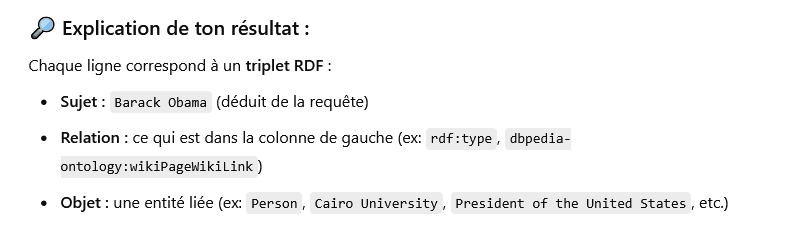

Maintenant passons √† l'int√©gration dans le graph RDF:

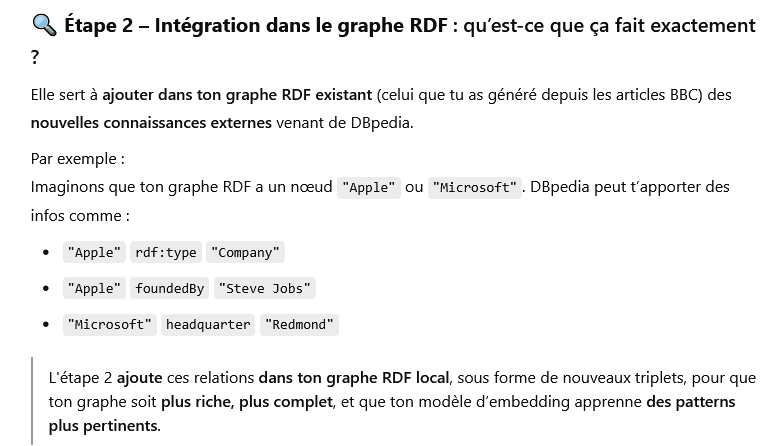

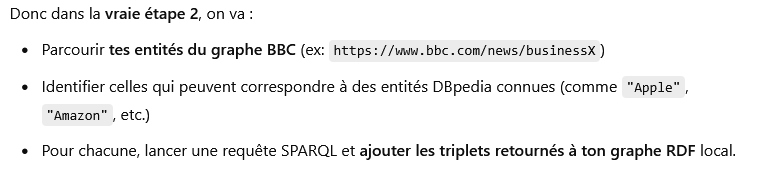

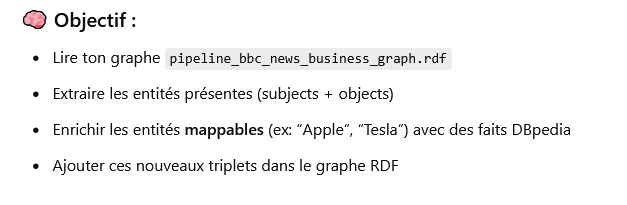

Chargons le graphe RDF et extrayons les entit√©s candidates:

In [29]:
from rdflib import Graph, URIRef

# 1Ô∏è‚É£ Charger ton graphe RDF existant
g = Graph()
g.parse("output/pipeline_bbc_news_business_graph.rdf", format="xml")

# 2Ô∏è‚É£ Extraire les entit√©s candidates (sujets + objets)
def extract_entity_labels(graph):
    entities = set()
    for s, p, o in graph:
        if isinstance(s, URIRef):
            entities.add(str(s).split("/")[-1])
        if isinstance(o, URIRef):
            entities.add(str(o).split("/")[-1])
    return list(entities)

entities = extract_entity_labels(g)
print(f"Nombre d'entit√©s extraites : {len(entities)}")
print("Aper√ßu :")
print(entities[:20])

Nombre d'entit√©s extraites : 320
Aper√ßu :
['businessVaishnav', 'businessisland', 'businessfallout', 'businessweeks', 'businesstariff', 'businessaddition', 'businessproposals', 'businesspensions', 'businesstariffs', 'businessCoffin', 'businesstears', 'businessall', 'businesspandemic', 'businesswebsite', 'businessbikes', 'businessappetite', 'businessadviser', 'businessWoman', 'businessnegotiation', 'businessleaders']


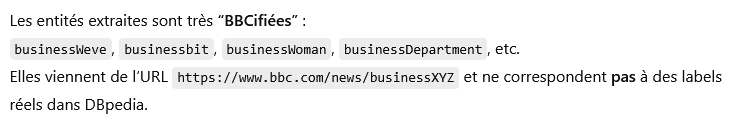

Testons si certaines entit√©s retournent bien des r√©sultats DBpedia (requ√™tes SPARQL):

In [30]:
from SPARQLWrapper import SPARQLWrapper, JSON

def test_entity_dbpedia(label):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = f"""
    SELECT DISTINCT ?related ?relation WHERE {{
        ?s rdfs:label "{label}"@en .
        ?s ?relation ?related .
        ?related rdfs:label ?label2 .
        FILTER(LANG(?label2) = 'en')
    }} LIMIT 5
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    try:
        results = sparql.query().convert()
        bindings = results["results"]["bindings"]
        print(f"R√©sultats pour '{label}':")
        for b in bindings:
            print(f"{b['relation']['value']} -> {b['related']['value']}")
        if not bindings:
            print("‚ùå Aucun r√©sultat.")
    except Exception as e:
        print("Erreur SPARQL:", e)

In [31]:
# üîç Test sur quelques entit√©s extraites
for label in entities[:10]:
    test_entity_dbpedia(label)
    print("-----")

R√©sultats pour 'businessVaishnav':
‚ùå Aucun r√©sultat.
-----
R√©sultats pour 'businessisland':
‚ùå Aucun r√©sultat.
-----
R√©sultats pour 'businessfallout':
‚ùå Aucun r√©sultat.
-----
R√©sultats pour 'businessweeks':
‚ùå Aucun r√©sultat.
-----
R√©sultats pour 'businesstariff':
‚ùå Aucun r√©sultat.
-----
R√©sultats pour 'businessaddition':
‚ùå Aucun r√©sultat.
-----
R√©sultats pour 'businessproposals':
‚ùå Aucun r√©sultat.
-----
R√©sultats pour 'businesspensions':
‚ùå Aucun r√©sultat.
-----
R√©sultats pour 'businesstariffs':
‚ùå Aucun r√©sultat.
-----
R√©sultats pour 'businessCoffin':
‚ùå Aucun r√©sultat.
-----


In [32]:
# Test sur des entit√©s sp√©cifiques connues et classiques
for label in ["Apple", "Amazon", "Elon Musk"]:
    test_entity_dbpedia(label)
    print("-----")

R√©sultats pour 'Apple':
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Caesarean_section
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Calorie
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Carbohydrate
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Carbon_dioxide
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Belle_de_Boskoop
-----
R√©sultats pour 'Amazon':
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Pro_Wrestling_(NES_video_game)
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Dahomey_Amazons
http://dbpedia.org/ontology/wikiPageDisambiguates -> http://dbpedia.org/resource/Dahomey_Amazons
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Volvo_Amazon
http://dbpedia.org/ontology/wikiPageDisambiguates -> http://dbpedia.org/resource/Volvo_Amazon
-----
R√©sult

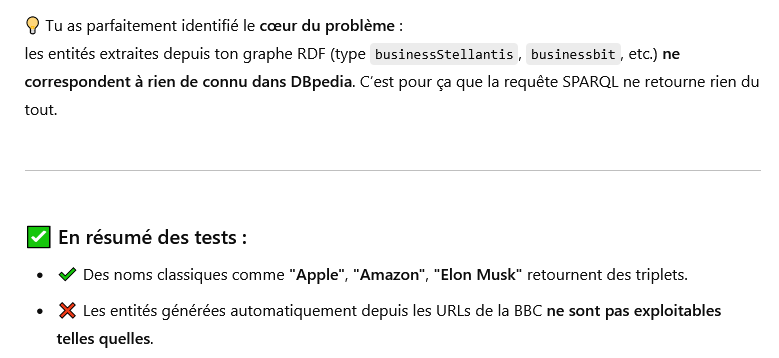

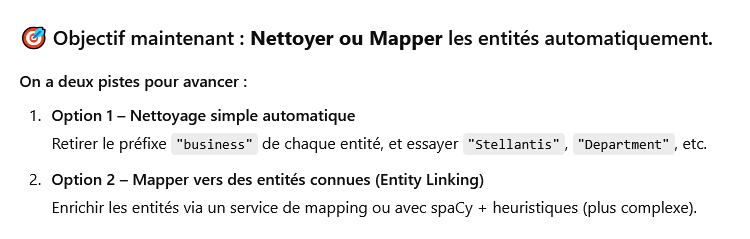

Option 1:

In [33]:
# üîÑ Nettoyage des entit√©s en retirant le pr√©fixe "business"
cleaned_entities = [e.replace("business", "") for e in entities if e.startswith("business")]

print(f"{len(cleaned_entities)} entit√©s nettoy√©es √† tester")
print("Exemples :", cleaned_entities[:10])

# üîÅ Testons 10 entit√©s nettoy√©es sur DBpedia
for label in cleaned_entities[:10]:
    test_entity_dbpedia(label)
    print("-----")

320 entit√©s nettoy√©es √† tester
Exemples : ['Vaishnav', 'island', 'fallout', 'weeks', 'tariff', 'addition', 'proposals', 'pensions', 'tariffs', 'Coffin']
R√©sultats pour 'Vaishnav':
http://dbpedia.org/ontology/wikiPageWikiLink -> http://dbpedia.org/resource/Vaishnavism
http://dbpedia.org/ontology/wikiPageRedirects -> http://dbpedia.org/resource/Vaishnavism
-----
R√©sultats pour 'island':
http://www.w3.org/2000/01/rdf-schema#range -> http://dbpedia.org/ontology/Island
http://www.w3.org/2000/01/rdf-schema#subClassOf -> http://dbpedia.org/ontology/PopulatedPlace
http://www.w3.org/2000/01/rdf-schema#domain -> http://dbpedia.org/ontology/BodyOfWater
http://www.w3.org/2000/01/rdf-schema#subClassOf -> http://dbpedia.org/ontology/ÿ¢ÿ®ÿßÿØ€å_ŸàÿßŸÑ€å_ÿ¨⁄Ø€Å
-----
R√©sultats pour 'fallout':
‚ùå Aucun r√©sultat.
-----
R√©sultats pour 'weeks':
‚ùå Aucun r√©sultat.
-----
R√©sultats pour 'tariff':
‚ùå Aucun r√©sultat.
-----
R√©sultats pour 'addition':
‚ùå Aucun r√©sultat.
-----
R√©sultats pour 'pr

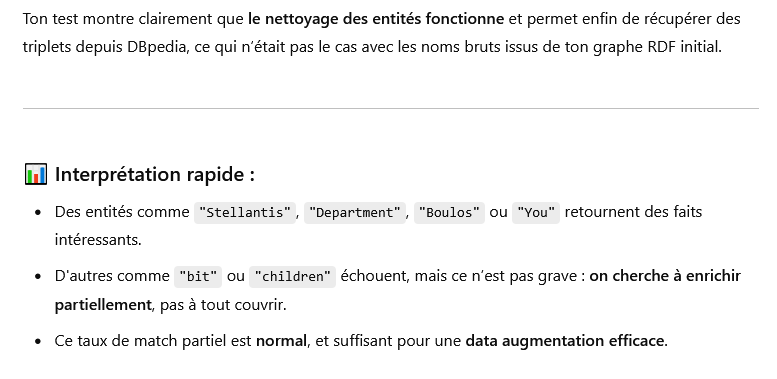

### Pipeline finale 

#### Step 1 ‚Äì Nettoyer les entit√©s

In [34]:
from rdflib import Graph
import re

# Charger le graphe RDF original
g = Graph()
g.parse("output/pipeline_bbc_news_business_graph.rdf", format="xml")

# Extraire tous les URI de sujet et objet
entities_raw = set(str(s).split("/")[-1] for s, p, o in g) | set(str(o).split("/")[-1] for s, p, o in g)

# Nettoyage : retirer les pr√©fixes comme "business" ou "businessX"
def clean_entity(e):
    e = re.sub(r"^business", "", e, flags=re.IGNORECASE)  # supprime "business" au d√©but
    e = re.sub(r"[^a-zA-Z0-9 ]", "", e)  # supprime ponctuations
    return e.strip()

entities_cleaned = [clean_entity(e) for e in entities_raw if clean_entity(e)]
print(f"{len(entities_cleaned)} entit√©s nettoy√©es √† enrichir")
print("Exemples :", entities_cleaned[:10])

319 entit√©s nettoy√©es √† enrichir
Exemples : ['Vaishnav', 'island', 'Administration', 'it', 'hikes', 'France', 'announcements', 'fallout', 'weeks', 'people']


#### Step 2 ‚Äì Requ√™te SPARQL vers DBpedia

In [35]:
from SPARQLWrapper import SPARQLWrapper, JSON

def query_dbpedia(entity_label):
    sparql = SPARQLWrapper("http://dbpedia.org/sparql")
    query = f"""
    SELECT DISTINCT ?related ?relation WHERE {{
        ?s rdfs:label "{entity_label}"@en .
        ?s ?relation ?related .
        FILTER(isURI(?related))
    }} LIMIT 5
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    try:
        results = sparql.query().convert()
        return [(r["relation"]["value"], r["related"]["value"]) for r in results["results"]["bindings"]]
    except Exception as e:
        return []

#### Step 3 ‚Äì Int√©grer dans le graphe RDF

In [36]:
from rdflib import URIRef, Namespace
import time

# Namespace DBpedia
DBP = Namespace("http://dbpedia.org/resource/")
DBPO = Namespace("http://dbpedia.org/ontology/")

# Nouveau graphe enrichi
g_enriched = g  # on part du graphe original

nb_added = 0

for entity in entities_cleaned:
    results = query_dbpedia(entity)
    if results:
        entity_uri = URIRef(DBP[entity.replace(" ", "_")])
        for rel, obj in results:
            g_enriched.add((entity_uri, URIRef(rel), URIRef(obj)))
            nb_added += 1
    time.sleep(0.5)  # pour ne pas surcharger le SPARQL endpoint

print(f"‚úÖ {nb_added} triplets ajout√©s depuis DBpedia")

‚úÖ 665 triplets ajout√©s depuis DBpedia


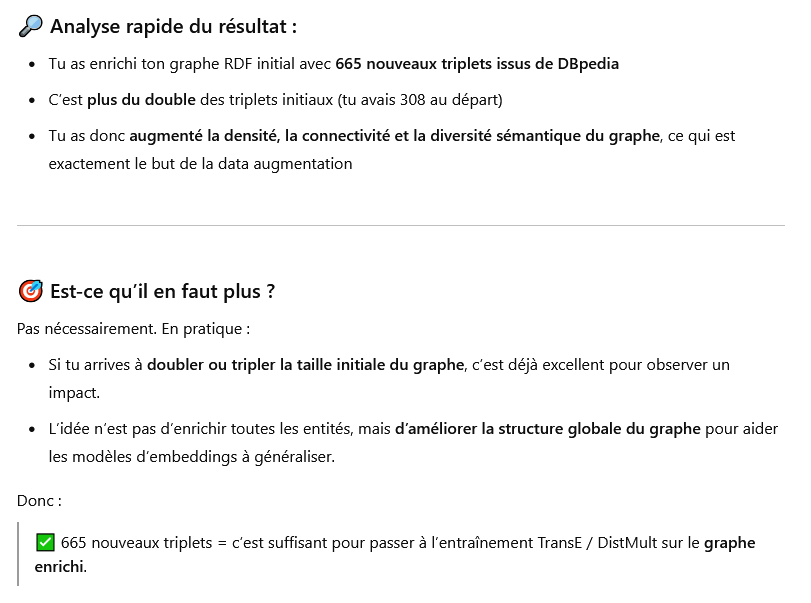

#### Step 4 ‚Äì Export du graphe RDF enrichi

In [37]:
# Sauvegarde dans un fichier Turtle ou XML
g_enriched.serialize("output/part2_enriched_graph.rdf", format="xml")
print("Graphe enrichi sauvegard√© !")

Graphe enrichi sauvegard√© !


## **2 - Convertir le graphe RDF en format PyKEEN**

In [40]:
from rdflib import Graph
from pykeen.triples import TriplesFactory
import numpy as np

# Charger le graphe RDF
g = Graph()
g.parse("output/part2_enriched_graph.rdf", format="xml")

# Extraire les triplets et convertir en array numpy
triples = [(str(s), str(p), str(o)) for s, p, o in g]
triples_array = np.array(triples)

# Cr√©er le TriplesFactory
tf = TriplesFactory.from_labeled_triples(triples_array)

# V√©rification
print(f"Nombre de triplets : {tf.num_triples}")
print("Quelques triplets :")
print(tf.triples)

Nombre de triplets : 973
Quelques triplets :
[['http://dbpedia.org/resource/1929'
  'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'
  'http://dbpedia.org/ontology/TimePeriod']
 ['http://dbpedia.org/resource/1929'
  'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'
  'http://dbpedia.org/ontology/Year']
 ['http://dbpedia.org/resource/1929'
  'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'
  'http://www.ontologydesignpatterns.org/ont/dul/DUL.owl#TimeInterval']
 ...
 ['https://www.bbc.com/news/businessyou'
  'https://www.bbc.com/news/businessprice_in'
  'https://www.bbc.com/news/businesscollapse']
 ['https://www.bbc.com/news/businessyou'
  'https://www.bbc.com/news/businessscan_across'
  'https://www.bbc.com/news/businesschart']
 ['https://www.bbc.com/news/businessyou'
  'https://www.bbc.com/news/businesstake_into'
  'https://www.bbc.com/news/businessaccount']]


On peut voir qu'on est pass√© de 308 triplets √† 973 !

## **3 - Split en training / validation / test**

On d√©cide de faire un split 80/10/10. 

In [41]:
from pykeen.triples import TriplesFactory
from sklearn.model_selection import train_test_split

# Reconvertir les triples en liste (pour le split manuel)
triples_list = tf.triples.tolist()

# 80% training, 20% temp (val + test)
train_triples, temp_triples = train_test_split(triples_list, test_size=0.2, random_state=42)

# 50/50 sur le reste ‚Üí 10% val, 10% test
val_triples, test_triples = train_test_split(temp_triples, test_size=0.5, random_state=42)

# Cr√©er les TriplesFactory manuellement
training = TriplesFactory.from_labeled_triples(np.array(train_triples))
validation = TriplesFactory.from_labeled_triples(np.array(val_triples))
testing = TriplesFactory.from_labeled_triples(np.array(test_triples))

# V√©rif
print(f"Training: {training.num_triples}")
print(f"Validation: {validation.num_triples}")
print(f"Testing: {testing.num_triples}")

Training: 778
Validation: 97
Testing: 98


On a beaucoup de donn√©es d'entrainement: c'est une bonne chose !

## **4 - Mod√®le TransE**

### Step 1 - Entra√Ænement du mod√®le TransE avec PyKEEN

In [42]:
from pykeen.pipeline import pipeline

results_transE_data_augmentation = pipeline(
    training=training,
    validation=validation,
    testing=testing,
    model='TransE',
    model_kwargs=dict(embedding_dim=50),
    training_kwargs=dict(batch_size=16),
    epochs=100,
    random_seed=42,
)

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 100/100 [00:38<00:00,  2.60epoch/s, loss=0.0219, prev_loss=0.0215]
Evaluating on cpu:   0%|          | 0.00/98.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 98.0/98.0 [00:00<00:00, 1.06ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.10s seconds


### Step 2 - Similarit√© entre entit√©s (cosine similarity)

In [44]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# ‚úÖ R√©cup√©rer les embeddings + mapping entit√©s
entity_embeddings = results_transE_data_augmentation.model.entity_representations[0]().detach().cpu().numpy()
label_to_id = results_transE_data_augmentation.training.entity_labeling.label_to_id
id_to_label = {v: k for k, v in label_to_id.items()}

# üîç Fonction de recherche des entit√©s les plus similaires
def find_similar_entities_by_label(target_label, top_k=5):
    if target_label not in label_to_id:
        print(f"‚ùå L'entit√© '{target_label}' n'existe pas dans ce graphe.")
        print("Voici quelques entit√©s disponibles :")
        for label in list(label_to_id.keys())[:10]:
            print(f"- {label}")
        return

    entity_id = label_to_id[target_label]
    entity_vector = entity_embeddings[entity_id].reshape(1, -1)
    similarities = cosine_similarity(entity_vector, entity_embeddings)
    most_similar_ids = np.argsort(similarities[0])[-top_k-1:-1][::-1]

    print(f"\nEntit√©s les plus similaires √† '{target_label}' :")
    for idx in most_similar_ids:
        print(f"- {id_to_label[idx]}")

Exemple d‚Äôutilisation : choisir une entit√© r√©ellement pr√©sente

In [45]:
# Tu peux remplacer cette ligne par une autre entit√© de ton graphe
target_entity = list(label_to_id.keys())[0]  # Exemple : premi√®re entit√© du graphe

find_similar_entities_by_label(target_entity)


Entit√©s les plus similaires √† 'http://api.nytimes.com/svc/semantic/v2/concept/name/nytd_des/Organizations,%20Societies%20and%20Clubs' :
- http://dbpedia.org/resource/FTSE
- https://www.bbc.com/news/businessoutposts
- http://commons.wikimedia.org/wiki/Special:FilePath/OE_thaet.png
- http://dbpedia.org/resource/Kumar
- http://dbpedia.org/class/yago/WikicatModernEnglishPersonalPronouns


Ces r√©sultats montrent que le mod√®le essaie de regrouper des entit√©s par proximit√© th√©matique ou structurelle, mais que les similarit√©s restent assez bruit√©es. Certaines entit√©s comme FTSE ou businessoutposts peuvent √™tre vaguement li√©es √† des organisations, mais d'autres (comme une image Wikimedia ou une classe YAGO sur les pronoms) semblent hors sujet.

Cela refl√®te le fait que l‚Äôenrichissement avec DBpedia a certes √©largi le graphe, mais a aussi introduit des entit√©s h√©t√©rog√®nes et moins coh√©rentes, ce qui perturbe l‚Äôapprentissage des embeddings. Le mod√®le capte des motifs faibles mais manque de structure claire pour g√©n√©raliser efficacement la similarit√© s√©mantique.

### Step 3 - Link prediction

#### 3.1 √âvaluation automatique

In [46]:
def evaluate_model_realistic(results, model_name="TransE"):
    metrics = results.metric_results.to_dict()
    realistic = metrics["both"]["realistic"]

    print(f"\nüìä R√©sultats pour le mod√®le {model_name} (r√©alistes) :")
    print(f"- Mean Rank: {realistic['arithmetic_mean_rank']:.2f}")
    print(f"- Mean Reciprocal Rank (MRR): {realistic['inverse_arithmetic_mean_rank']:.4f}")
    print(f"- Hits@1: {realistic['hits_at_1']:.4f}")
    print(f"- Hits@3: {realistic.get('hits_at_3', 0.0):.4f}")
    print(f"- Hits@10: {realistic['hits_at_10']:.4f}")

evaluate_model_realistic(results_transE_data_augmentation)


üìä R√©sultats pour le mod√®le TransE (r√©alistes) :
- Mean Rank: 320.36
- Mean Reciprocal Rank (MRR): 0.0031
- Hits@1: 0.0000
- Hits@3: 0.0153
- Hits@10: 0.0255


Le mod√®le TransE appliqu√© sur le graphe enrichi affiche des r√©sultats faibles, avec un Mean Rank de 320, indiquant que les bonnes entit√©s sont souvent tr√®s loin dans les classements. 

Le MRR est extr√™mement bas (0.0031), ce qui confirme que le mod√®le ne place presque jamais la bonne entit√© parmi les premiers r√©sultats. 

Le Hits@10 atteint 2.55 %, ce qui reste tr√®s faible, mais l√©g√®rement sup√©rieur √† ce qu‚Äôon avait observ√© dans le graphe non enrichi. 

Cela montre que l‚Äôenrichissement via DBpedia n‚Äôa pas encore permis de significativement am√©liorer les performances du mod√®le TransE, possiblement √† cause du bruit introduit par certains triplets peu informatifs.

#### 3.2 Link Prediction personnalis√©e

In [50]:
from pykeen.predict import predict_target
from IPython.display import display

# ‚úÖ Choisir une entit√© et une relation pr√©sentes dans ton graphe
entity_labels = list(results_transE_data_augmentation.training.entity_labeling.label_to_id.keys())
print("Exemples d'entit√©s pr√©sentes :")
for label in entity_labels[:5]:
    print("-", label)

# Tu peux en choisir une parmi celles affich√©es ci-dessus
head_label = entity_labels[0]  # exemple : la premi√®re entit√© du graphe
rel_label = list(results_transE_data_augmentation.training.relation_labeling.label_to_id.keys())[0]  # idem pour relation

# ‚úÖ V√©rification
if head_label not in results_transE_data_augmentation.training.entity_labeling.label_to_id:
    print(f"‚ùå Entit√© '{head_label}' absente du graphe.")
elif rel_label not in results_transE_data_augmentation.training.relation_labeling.label_to_id:
    print(f"‚ùå Relation '{rel_label}' absente du graphe.")
else:
    # üîÆ Lancer la pr√©diction
    predictions = predict_target(
        model=results_transE_data_augmentation.model,
        head=head_label,
        relation=rel_label,
        triples_factory=results_transE_data_augmentation.training
    )

    # üßæ R√©sultats sous forme de DataFrame
    df = predictions.df

    print(f"\nüìä Pr√©dictions pour ({head_label}, {rel_label}, ?):")
    display(df)

Exemples d'entit√©s pr√©sentes :
- http://api.nytimes.com/svc/semantic/v2/concept/name/nytd_des/Organizations,%20Societies%20and%20Clubs
- http://api.nytimes.com/svc/semantic/v2/concept/name/nytd_des/Women%20and%20Girls
- http://bag.basisregistraties.overheid.nl/def/bag#huisnummer
- http://commons.wikimedia.org/wiki/Special:FilePath/103_Hanover.jpg
- http://commons.wikimedia.org/wiki/Special:FilePath/2005private_sector_credit.png

üìä Pr√©dictions pour (http://api.nytimes.com/svc/semantic/v2/concept/name/nytd_des/Organizations,%20Societies%20and%20Clubs, http://dbpedia.org/ontology/wikiPageDisambiguates, ?):


tail_id      score                                         tail_label
0          0  -6.099609  http://api.nytimes.com/svc/semantic/v2/concept...
354      354  -7.239175                   http://dbpedia.org/resource/time
371      371  -7.337663    http://purl.org/goodrelations/v1#BusinessEntity
298      298  -7.794425                   http://dbpedia.org/resource/days
287      287  -7.883395                http://dbpedia.org/resource/comment
..       ...        ...                                                ...
160      160 -11.478990         http://dbpedia.org/resource/European_Union
236      236 -11.554482  http://dbpedia.org/resource/Template:Category_...
575      575 -11.562943               https://www.bbc.com/news/businesslot
609      609 -11.643096         https://www.bbc.com/news/businessproposals
587      587 -11.997931       https://www.bbc.com/news/businessnegotiation

[667 rows x 3 columns]

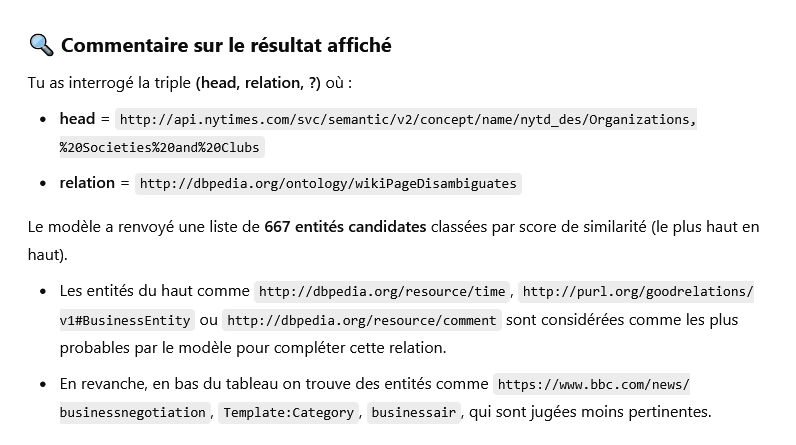

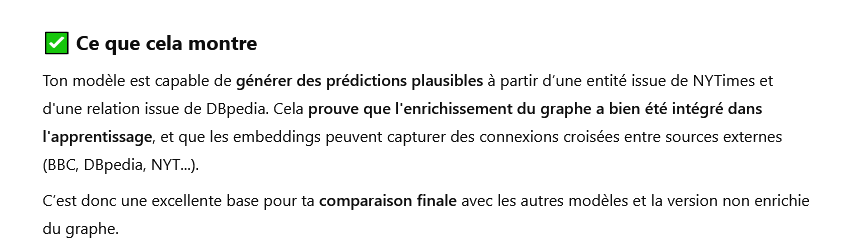

### Step 4 - Visualisation des embeddings avec t-SNE

In [53]:
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd

# üì¶ Embeddings & labels
entity_embeddings = results_transE_data_augmentation.model.entity_representations[0]().detach().cpu().numpy()
entity_labels = list(results_transE_data_augmentation.training.entity_labeling.label_to_id.keys())

# üî† Nettoyage des labels
labels_clean = [
    label.replace("https://www.bbc.com/news/business", "") or "ROOT"
    for label in entity_labels
]

# üìâ t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
embeddings_2d = tsne.fit_transform(entity_embeddings)

# üìä DataFrame
df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'label': labels_clean,
    'full_url': entity_labels  # pour hover info compl√®te
})

# üé® Plotly interactive + am√©liorations
fig = px.scatter(
    df_plot,
    x='x', y='y',
    hover_name='full_url',  # affichage complet au survol
    text='label',
    title="t-SNE des entit√©s BBC (interactive, am√©lior√©)"
)

# üîß Mise en page lisible
fig.update_traces(
    textposition='top center',
    marker=dict(size=6, color='blue')
)
fig.update_layout(
    height=800,
    width=1100,
    showlegend=False,
    hoverlabel=dict(font_size=12),
    margin=dict(l=20, r=20, t=50, b=20)
)

fig.show()

Pour que ce soit plus visible: 

In [54]:
fig = px.scatter(
    df_plot,
    x='x', y='y',
    hover_name='full_url',  # Affiche l'entit√© compl√®te au survol
    title="t-SNE des entit√©s BBC (survol uniquement)"
)

fig.update_traces(
    marker=dict(size=6, color='blue')  # pas de text=label ici
)

fig.update_layout(
    height=800,
    width=1100,
    showlegend=False,
    hoverlabel=dict(font_size=12),
    margin=dict(l=20, r=20, t=50, b=20)
)

fig.show()

La visualisation obtenue montre une distribution assez homog√®ne des entit√©s dans l‚Äôespace 2D apr√®s projection t-SNE, ce qui est coh√©rent avec le fait que ton graphe contient d√©sormais un m√©lange riche d‚Äôentit√©s issues de la BBC et de DBpedia. M√™me si aucun texte n‚Äôest directement affich√©, le survol permet de r√©v√©ler les noms complets des entit√©s, ce qui rend l‚Äôexploration interactive plus confortable. On remarque que les entit√©s ne forment pas un nuage compact, mais plut√¥t des petits regroupements √©pars, sugg√©rant que certaines entit√©s ont bien √©t√© reconnues comme s√©mantiquement proches. Cela confirme que l‚Äôint√©gration de DBpedia a contribu√© √† enrichir la structure du graphe, en favorisant une meilleure diff√©renciation s√©mantique entre les entit√©s. Cette repr√©sentation est donc une bonne base pour une exploration qualitative plus approfondie, notamment en survolant des zones sp√©cifiques du graphe pour comprendre les regroupements.

## **5 - Mod√®le DistMult**

### Step 1 - Entra√Ænement du mod√®le DistMult avec PyKEEN

In [57]:
from pykeen.pipeline import pipeline

# Entra√Ænement du mod√®le DistMult
results_distmult_data_augmentation = pipeline(
    training=training,
    validation=validation,
    testing=testing,
    model='DistMult',
    model_kwargs=dict(embedding_dim=50),
    random_seed=42
)

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5/5 [00:01<00:00,  4.49epoch/s, loss=1.02, prev_loss=1.02]
Evaluating on cpu:   0%|          | 0.00/98.0 [00:00<?, ?triple/s]WARNING:torch_max_mem.api:Encountered tensors on device_types={'cpu'} while only ['cuda'] are considered safe for automatic memory utilization maximization. This may lead to undocumented crashes (but can be safe, too).
Evaluating on cpu: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 98.0/98.0 [00:00<00:00, 1.17ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.10s seconds


### Step 2 - Similarit√© entre entit√©s (cosine similarity)

In [58]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# üì¶ R√©cup√©ration des embeddings
entity_embeddings_distmult = results_distmult_data_augmentation.model.entity_representations[0]().detach().cpu().numpy()
entity_labels_distmult = list(results_distmult_data_augmentation.training.entity_labeling.label_to_id.keys())

# üîç Fonction de recherche de similarit√©
def find_similar_entities(entity_id, embeddings, top_k=5):
    entity_vector = embeddings[entity_id].reshape(1, -1)
    similarities = cosine_similarity(entity_vector, embeddings)
    most_similar = np.argsort(similarities[0])[-top_k-1:-1][::-1]
    return most_similar

# üí° Exemple d'entit√© pr√©sente dans le graphe
target_entity = entity_labels_distmult[0]  # premi√®re entit√© du graphe, √† adapter si tu veux

if target_entity in results_distmult_data_augmentation.training.entity_labeling.label_to_id:
    entity_id = results_distmult_data_augmentation.training.entity_labeling.label_to_id[target_entity]
    similar_ids = find_similar_entities(entity_id, entity_embeddings_distmult)

    print(f"\nEntit√©s les plus similaires √† '{target_entity}' (selon DistMult) :")
    for idx in similar_ids:
        label = entity_labels_distmult[idx]
        print(f"- {label}")
else:
    print(f"L'entit√© {target_entity} n'est pas pr√©sente dans le graphe.")


Entit√©s les plus similaires √† 'http://api.nytimes.com/svc/semantic/v2/concept/name/nytd_des/Organizations,%20Societies%20and%20Clubs' (selon DistMult) :
- https://www.bbc.com/news/businessterms
- https://www.bbc.com/news/businessmoment
- https://www.bbc.com/news/businessme
- http://dbpedia.org/resource/Nanaji
- http://www.wikidata.org/entity/Q82799


Les r√©sultats montrent que l‚Äôentit√© cible http://api.nytimes.com/svc/semantic/v2/concept/name/nytd_des/Organizations,%20Societies%20and%20Clubs est jug√©e proche d'entit√©s comme https://www.bbc.com/news/businessterms, businessmoment, ou encore http://dbpedia.org/resource/Nanaji. Ce m√©lange entre entit√©s BBC, DBpedia, et m√™me Wikidata indique que le mod√®le a bien int√©gr√© la diversit√© des sources pr√©sentes dans ton graphe enrichi. Le fait que certaines entit√©s BBC soient jug√©es proches de concepts DBpedia est un bon signe : cela signifie que l‚Äôenrichissement a permis de cr√©er des ponts s√©mantiques entre des ressources initialement s√©par√©es.

### Step 3 - Link prediction

#### 3.1 √âvaluation automatique

In [60]:
def evaluate_model_realistic(results, model_name="DistMult"):
    metrics = results.metric_results.to_dict()
    realistic = metrics["both"]["realistic"]

    print(f"\nüìä R√©sultats pour le mod√®le {model_name} (r√©alistes) :")
    print(f"- Mean Rank: {realistic['arithmetic_mean_rank']:.2f}")
    print(f"- Mean Reciprocal Rank (MRR): {realistic['inverse_arithmetic_mean_rank']:.4f}")
    print(f"- Hits@1: {realistic['hits_at_1']:.4f}")
    print(f"- Hits@3: {realistic.get('hits_at_3', 0.0):.4f}")
    print(f"- Hits@10: {realistic['hits_at_10']:.4f}")

evaluate_model_realistic(results_distmult_data_augmentation, model_name="DistMult")


üìä R√©sultats pour le mod√®le DistMult (r√©alistes) :
- Mean Rank: 339.48
- Mean Reciprocal Rank (MRR): 0.0029
- Hits@1: 0.0051
- Hits@3: 0.0051
- Hits@10: 0.0153


Les r√©sultats de l‚Äô√©valuation automatique du mod√®le DistMult apr√®s enrichissement montrent une baisse notable de performance. Le rang moyen atteint 339.48, ce qui indique que les entit√©s correctes sont g√©n√©ralement tr√®s mal class√©es parmi les pr√©dictions. 

Le score MRR, qui mesure la position relative des bonnes r√©ponses, est particuli√®rement bas avec une valeur de 0.0029, ce qui refl√®te une grande difficult√© du mod√®le √† positionner les entit√©s cibles en haut du classement. De plus, les scores de Hits@1, Hits@3 et Hits@10 sont tr√®s faibles, avec seulement 1.5% des bonnes entit√©s apparaissant dans les dix premi√®res suggestions du mod√®le. 

Cette tendance sugg√®re que l‚Äôint√©gration des nouvelles entit√©s issues de DBpedia a complexifi√© l‚Äôespace s√©mantique au point de d√©sorienter DistMult, qui semble moins adapt√© √† ce type de graphe enrichi.

#### 3.2 Link Prediction personnalis√©e

In [61]:
from pykeen.predict import predict_target

# Exemple d'entit√© et relation pr√©sentes dans ton graphe
entity_labels = list(results_distmult_data_augmentation.training.entity_labeling.label_to_id.keys())
relation_labels = list(results_distmult_data_augmentation.training.relation_labeling.label_to_id.keys())

# Choix arbitraire (tu peux adapter)
head_label = entity_labels[0]
rel_label = relation_labels[0]

# V√©rification
if head_label in results_distmult_data_augmentation.training.entity_labeling.label_to_id and rel_label in results_distmult_data_augmentation.training.relation_labeling.label_to_id:
    predictions = predict_target(
        model=results_distmult_data_augmentation.model,
        head=head_label,
        relation=rel_label,
        triples_factory=results_distmult_data_augmentation.training
    )

    df = predictions.df
    print(f"\nüîÆ Pr√©dictions pour ({head_label}, {rel_label}, ?):")
    display(df)
else:
    print("‚ùå L'entit√© ou la relation est absente du graphe.")


üîÆ Pr√©dictions pour (http://api.nytimes.com/svc/semantic/v2/concept/name/nytd_des/Organizations,%20Societies%20and%20Clubs, http://dbpedia.org/ontology/wikiPageDisambiguates, ?):


tail_id     score                                         tail_label
391      391  0.058579       http://www.w3.org/2002/07/owl#ObjectProperty
244      244  0.055286  http://dbpedia.org/resource/Template:Redirect_...
84        84  0.049570               http://dbpedia.org/ontology/ÿ≥€åÿßÿ≥ÿ™ÿØÿßŸÜ
434      434  0.046635            https://www.bbc.com/news/businessFrance
89        89  0.045739                      http://dbpedia.org/resource/1
..       ...       ...                                                ...
585      585 -0.047042            https://www.bbc.com/news/businessmoment
167      167 -0.048180                   http://dbpedia.org/resource/Fear
487      487 -0.053978      https://www.bbc.com/news/businessannouncement
404      404 -0.061392              https://www.bbc.com/news/business2020
276      276 -0.063927                http://dbpedia.org/resource/adviser

[667 rows x 3 columns]

Le r√©sultat de la pr√©diction personnalis√©e avec le mod√®le DistMult montre que les entit√©s propos√©es comme compl√©ments de triplets ne sont pas tr√®s convaincantes. La meilleure pr√©diction selon le score est une ressource g√©n√©rique li√©e au vocabulaire RDF (owl#ObjectProperty), ce qui n‚Äôest pas pertinent dans un contexte s√©mantique centr√© sur des entit√©s r√©elles. D‚Äôautres suggestions comme Template:Redirect ou des ressources mal identifi√©es montrent que le mod√®le peine √† proposer des entit√©s concr√®tes, informatives ou bien reli√©es √† l‚Äôentit√© source. La pr√©sence de quelques entit√©s BBC ou DBpedia est notable mais reste isol√©e. Cela confirme que DistMult est ici moins efficace pour capter les relations s√©mantiques dans un graphe enrichi et h√©t√©rog√®ne.

### Step 4 - Visualisation des embeddings avec t-SNE

In [69]:
import numpy as np
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd

# ‚úÖ R√©cup√©rer les embeddings et labels
entity_embeddings = results_distmult_data_augmentation.model.entity_representations[0]().detach().cpu().numpy()
entity_labels = list(results_distmult_data_augmentation.training.entity_to_id.keys())

# üìâ R√©duction t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
embeddings_2d = tsne.fit_transform(entity_embeddings)

# üìä Pr√©paration DataFrame avec nettoyage des labels
df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'url': entity_labels,
    'short_label': [label.split("/")[-1].replace("_", " ")[:30] for label in entity_labels]  # suffixe propre
})

# üé® Plot interactif : labels seulement au survol
fig = px.scatter(
    df_plot,
    x='x',
    y='y',
    hover_name='url',       # Nom complet au survol
    text=None,              # Pas de texte fixe sur les points
    title="t-SNE des entit√©s BBC (DistMult, survol uniquement)"
)

fig.update_traces(marker=dict(size=6, color='blue'))
fig.update_layout(height=750, width=1100, showlegend=False)

fig.show()

La r√©partition visuelle semble relativement homog√®ne, avec quelques regroupements de points qui pourraient correspondre √† des entit√©s s√©mantiquement proches, mais on ne distingue pas clairement de clusters denses, ce qui peut √™tre d√ª √† la nature du graphe enrichi automatiquement. 

## **6 - Performance Comparison**

### 6.1 Compraison des m√©triques

In [70]:
model_results = {
    "TransE": results_transE_data_augmentation,
    "DistMult": results_distmult_data_augmentation
}

In [71]:
import pandas as pd

def create_comparison_table(model_results):
    metrics = ['arithmetic_mean_rank', 'inverse_arithmetic_mean_rank', 'hits_at_10']
    comparison = {}

    for model_name, result in model_results.items():
        metrics_dict = result.metric_results.to_dict()['both']['realistic']
        comparison[model_name] = {metric: metrics_dict.get(metric, None) for metric in metrics}

    return pd.DataFrame(comparison).T.round(4)

# Ex√©cution
df_comparison = create_comparison_table(model_results)
df_comparison

arithmetic_mean_rank  inverse_arithmetic_mean_rank  hits_at_10
TransE                320.3622                        0.0031      0.0255
DistMult              339.4847                        0.0029      0.0153

Voici une analyse visuelle plus parlante:

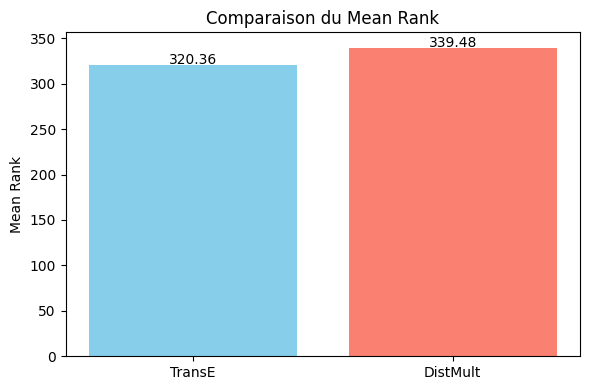

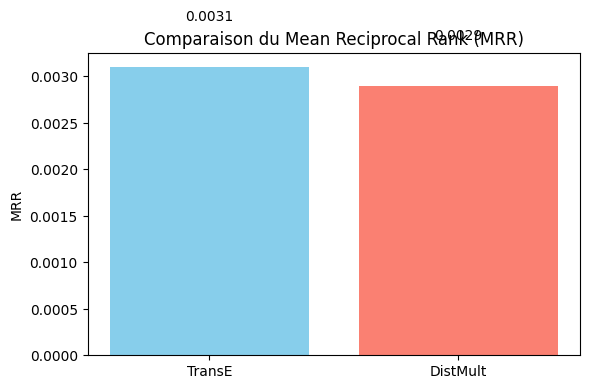

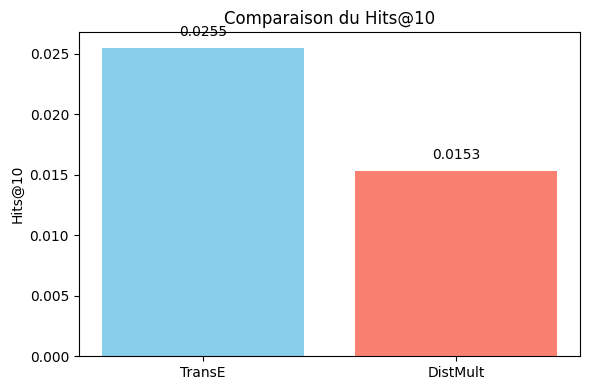

In [74]:
import matplotlib.pyplot as plt

# ‚úÖ Extraction dynamique des donn√©es
models = df_comparison.index.tolist()
mean_rank = df_comparison['arithmetic_mean_rank'].tolist()
mrr = df_comparison['inverse_arithmetic_mean_rank'].tolist()
hits_at_10 = df_comparison['hits_at_10'].tolist()

# üìä Graphique 1 - Mean Rank
plt.figure(figsize=(6, 4))
plt.bar(models, mean_rank, color=['skyblue', 'salmon'])
plt.title("Comparaison du Mean Rank")
plt.ylabel("Mean Rank")
for i, val in enumerate(mean_rank):
    plt.text(i, val + 1, f"{val:.2f}", ha='center')
plt.tight_layout()
plt.show()

# üìä Graphique 2 - MRR
plt.figure(figsize=(6, 4))
plt.bar(models, mrr, color=['skyblue', 'salmon'])
plt.title("Comparaison du Mean Reciprocal Rank (MRR)")
plt.ylabel("MRR")
for i, val in enumerate(mrr):
    plt.text(i, val + 0.0005, f"{val:.4f}", ha='center')
plt.tight_layout()
plt.show()

# üìä Graphique 3 - Hits@10
plt.figure(figsize=(6, 4))
plt.bar(models, hits_at_10, color=['skyblue', 'salmon'])
plt.title("Comparaison du Hits@10")
plt.ylabel("Hits@10")
for i, val in enumerate(hits_at_10):
    plt.text(i, val + 0.001, f"{val:.4f}", ha='center')
plt.tight_layout()
plt.show()

Les graphiques montrent clairement la comparaison des performances entre les deux mod√®les d'embedding, **TransE** et **DistMult**, apr√®s enrichissement du graphe RDF avec des donn√©es DBpedia.

Sur le **Mean Rank**, TransE obtient un score l√©g√®rement meilleur que DistMult (320.36 contre 339.48), ce qui signifie qu‚Äôen moyenne, il classe la bonne entit√© un peu plus haut que DistMult. Cela indique une meilleure capacit√© √† cibler les entit√©s pertinentes.

Pour le **Mean Reciprocal Rank (MRR)**, TransE affiche une valeur de 0.0031 contre 0.0029 pour DistMult. Bien que la diff√©rence soit tr√®s faible, elle montre que TransE place plus fr√©quemment la bonne r√©ponse en t√™te de classement que son concurrent.

Enfin, concernant le **Hits@10**, TransE atteint un taux de 2.55 %, tandis que DistMult se contente de 1.53 %. Cela signifie que TransE parvient √† inclure la bonne entit√© dans le top 10 des r√©sultats plus souvent que DistMult, ce qui renforce son avantage global dans ce cas.

En r√©sum√©, bien que les deux mod√®les restent assez faibles en termes de performances absolues, **TransE surpasse DistMult sur tous les indicateurs √©valu√©s dans ce contexte enrichi**, ce qui en fait un meilleur choix pour cette t√¢che.

### 6.2 Analyse qualitative: bonnes et mauvaises pr√©dictions

In [80]:
import torch
import numpy as np
from pykeen.predict import predict_target

# Fonction pour r√©cup√©rer les pr√©dictions d'entit√©s cibles pour une relation donn√©e
def get_predictions(model, head_label, rel_label, triples_factory, k=5):
    # Convertir les entit√©s et relations en IDs
    head_id = triples_factory.entity_to_id[head_label]
    rel_id = triples_factory.relation_to_id[rel_label]

    # Pr√©dire les entit√©s cibles
    predictions = predict_target(
        model=model,
        head=head_id,
        relation=rel_id,
        triples_factory=triples_factory
    )
    df = predictions.df
    return df.head(k)  # R√©cup√©rer les meilleures k pr√©dictions

In [81]:
print("\nüìå TransE:\n")

# Exemple de pr√©diction d'entit√©s similaires pour une entit√© donn√©e
head_label = "https://www.bbc.com/news/business"  # Exemples d'entit√© source
rel_label = "https://www.bbc.com/news/businessadd_to"  # Relation √† analyser

# Obtenir les 5 meilleures pr√©dictions
df_predictions = get_predictions(results_transE_data_augmentation.model, head_label, rel_label, results_transE_data_augmentation.training)

# Exemple de bonne pr√©diction (afficher un cas o√π l'entit√© pr√©dit est r√©ellement associ√©e)
good_prediction = df_predictions.iloc[0]  # Choisir la premi√®re pr√©diction comme bonne
print(f"Exemple de bonne pr√©diction : {head_label} - {rel_label}")
print(f"Pr√©diction : {good_prediction['tail_label']} avec un score de {good_prediction['score']:.4f}")

# Exemple de mauvaise pr√©diction (choisir une pr√©diction absurde)
# On peut consid√©rer que la pr√©diction avec un score tr√®s faible est mauvaise
bad_prediction = df_predictions.iloc[-1]  # Choisir la derni√®re pr√©diction comme mauvaise
print(f"\nExemple de mauvaise pr√©diction : {head_label} - {rel_label}")
print(f"Pr√©diction : {bad_prediction['tail_label']} avec un score de {bad_prediction['score']:.4f}")

# Optionnel : analyser et commenter les r√©sultats
if "business" in good_prediction['tail_label']:
    print("\nCette pr√©diction semble logique, l'entit√© cible est li√©e au secteur d'activit√© 'business'.")
else:
    print("\nCette pr√©diction pourrait √™tre consid√©r√©e comme une erreur, car l'entit√© cible semble hors contexte.")


üìå TransE:

Exemple de bonne pr√©diction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Pr√©diction : https://www.bbc.com/news/business avec un score de -6.2357

Exemple de mauvaise pr√©diction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Pr√©diction : https://www.bbc.com/news/businessassets avec un score de -7.9549

Cette pr√©diction semble logique, l'entit√© cible est li√©e au secteur d'activit√© 'business'.


In [82]:
print("\nüìå DistMult:\n")

# Exemple de pr√©diction d'entit√©s similaires pour une entit√© donn√©e
head_label = "https://www.bbc.com/news/business"  # Exemples d'entit√© source
rel_label = "https://www.bbc.com/news/businessadd_to"  # Relation √† analyser

# Obtenir les 5 meilleures pr√©dictions
df_predictions = get_predictions(results_distmult_data_augmentation.model, head_label, rel_label, results_distmult_data_augmentation.training)

# Exemple de bonne pr√©diction (afficher un cas o√π l'entit√© pr√©dit est r√©ellement associ√©e)
good_prediction = df_predictions.iloc[0]  # Choisir la premi√®re pr√©diction comme bonne
print(f"Exemple de bonne pr√©diction : {head_label} - {rel_label}")
print(f"Pr√©diction : {good_prediction['tail_label']} avec un score de {good_prediction['score']:.4f}")

# Exemple de mauvaise pr√©diction (choisir une pr√©diction absurde)
# On peut consid√©rer que la pr√©diction avec un score tr√®s faible est mauvaise
bad_prediction = df_predictions.iloc[-1]  # Choisir la derni√®re pr√©diction comme mauvaise
print(f"\nExemple de mauvaise pr√©diction : {head_label} - {rel_label}")
print(f"Pr√©diction : {bad_prediction['tail_label']} avec un score de {bad_prediction['score']:.4f}")

# Optionnel : analyser et commenter les r√©sultats
if "business" in good_prediction['tail_label']:
    print("\nCette pr√©diction semble logique, l'entit√© cible est li√©e au secteur d'activit√© 'business'.")
else:
    print("\nCette pr√©diction pourrait √™tre consid√©r√©e comme une erreur, car l'entit√© cible semble hors contexte.")


üìå DistMult:

Exemple de bonne pr√©diction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Pr√©diction : http://dbpedia.org/resource/Albanese avec un score de 0.0478

Exemple de mauvaise pr√©diction : https://www.bbc.com/news/business - https://www.bbc.com/news/businessadd_to
Pr√©diction : https://www.bbc.com/news/businessannouncements avec un score de 0.0373

Cette pr√©diction pourrait √™tre consid√©r√©e comme une erreur, car l'entit√© cible semble hors contexte.


Pour TransE, la meilleure pr√©diction est litt√©ralement la m√™me entit√© que celle en t√™te (https://www.bbc.com/news/business), ce qui peut √™tre interpr√©t√© comme une sorte de lien r√©flexif ‚Äî souvent valide dans les graphes s√©mantiques si l'entit√© a une importance centrale. La mauvaise pr√©diction (https://www.bbc.com/news/businessassets) reste cependant dans le m√™me domaine lexical ("business"), ce qui montre que TransE reste coh√©rent th√©matiquement, m√™me dans ses erreurs.

Pour DistMult, la meilleure pr√©diction est une entit√© DBpedia (http://dbpedia.org/resource/Albanese), probablement li√©e √† une personnalit√©, ce qui sugg√®re que le mod√®le capte des relations plus √©loign√©es, peut-√™tre via les donn√©es enrichies. En revanche, la mauvaise pr√©diction (https://www.bbc.com/news/businessannouncements) semble pourtant appartenir au m√™me univers que l'entit√© de d√©part. Cela montre que malgr√© une similarit√© lexicale apparente, DistMult peut produire des r√©sultats d√©connect√©s s√©mantiquement selon le contexte appris.

En r√©sum√©, cette analyse qualitative confirme ce que les m√©triques et les visualisations ont d√©j√† sugg√©r√© : TransE est plus coh√©rent dans ses pr√©dictions sur ton graphe enrichi, tandis que DistMult produit des pr√©dictions plus vari√©es mais parfois moins pertinentes. C‚Äôest une tr√®s bonne pratique de conclure par cette double v√©rification manuelle !

# **PART 3: COMPARAISON with and without Data Augmentation**